## Import Libraries

In [38]:
!pip install matplotlib wordcloud
!pip install --upgrade scikit-learn

import pandas as pd
import numpy as np
import nltk
import re
import ast
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Visualisation

First few titles:
0    Five Came Back: The Reference Films
1                            Taxi Driver
2                            Deliverance
3        Monty Python and the Holy Grail
4                        The Dirty Dozen
Name: title, dtype: object




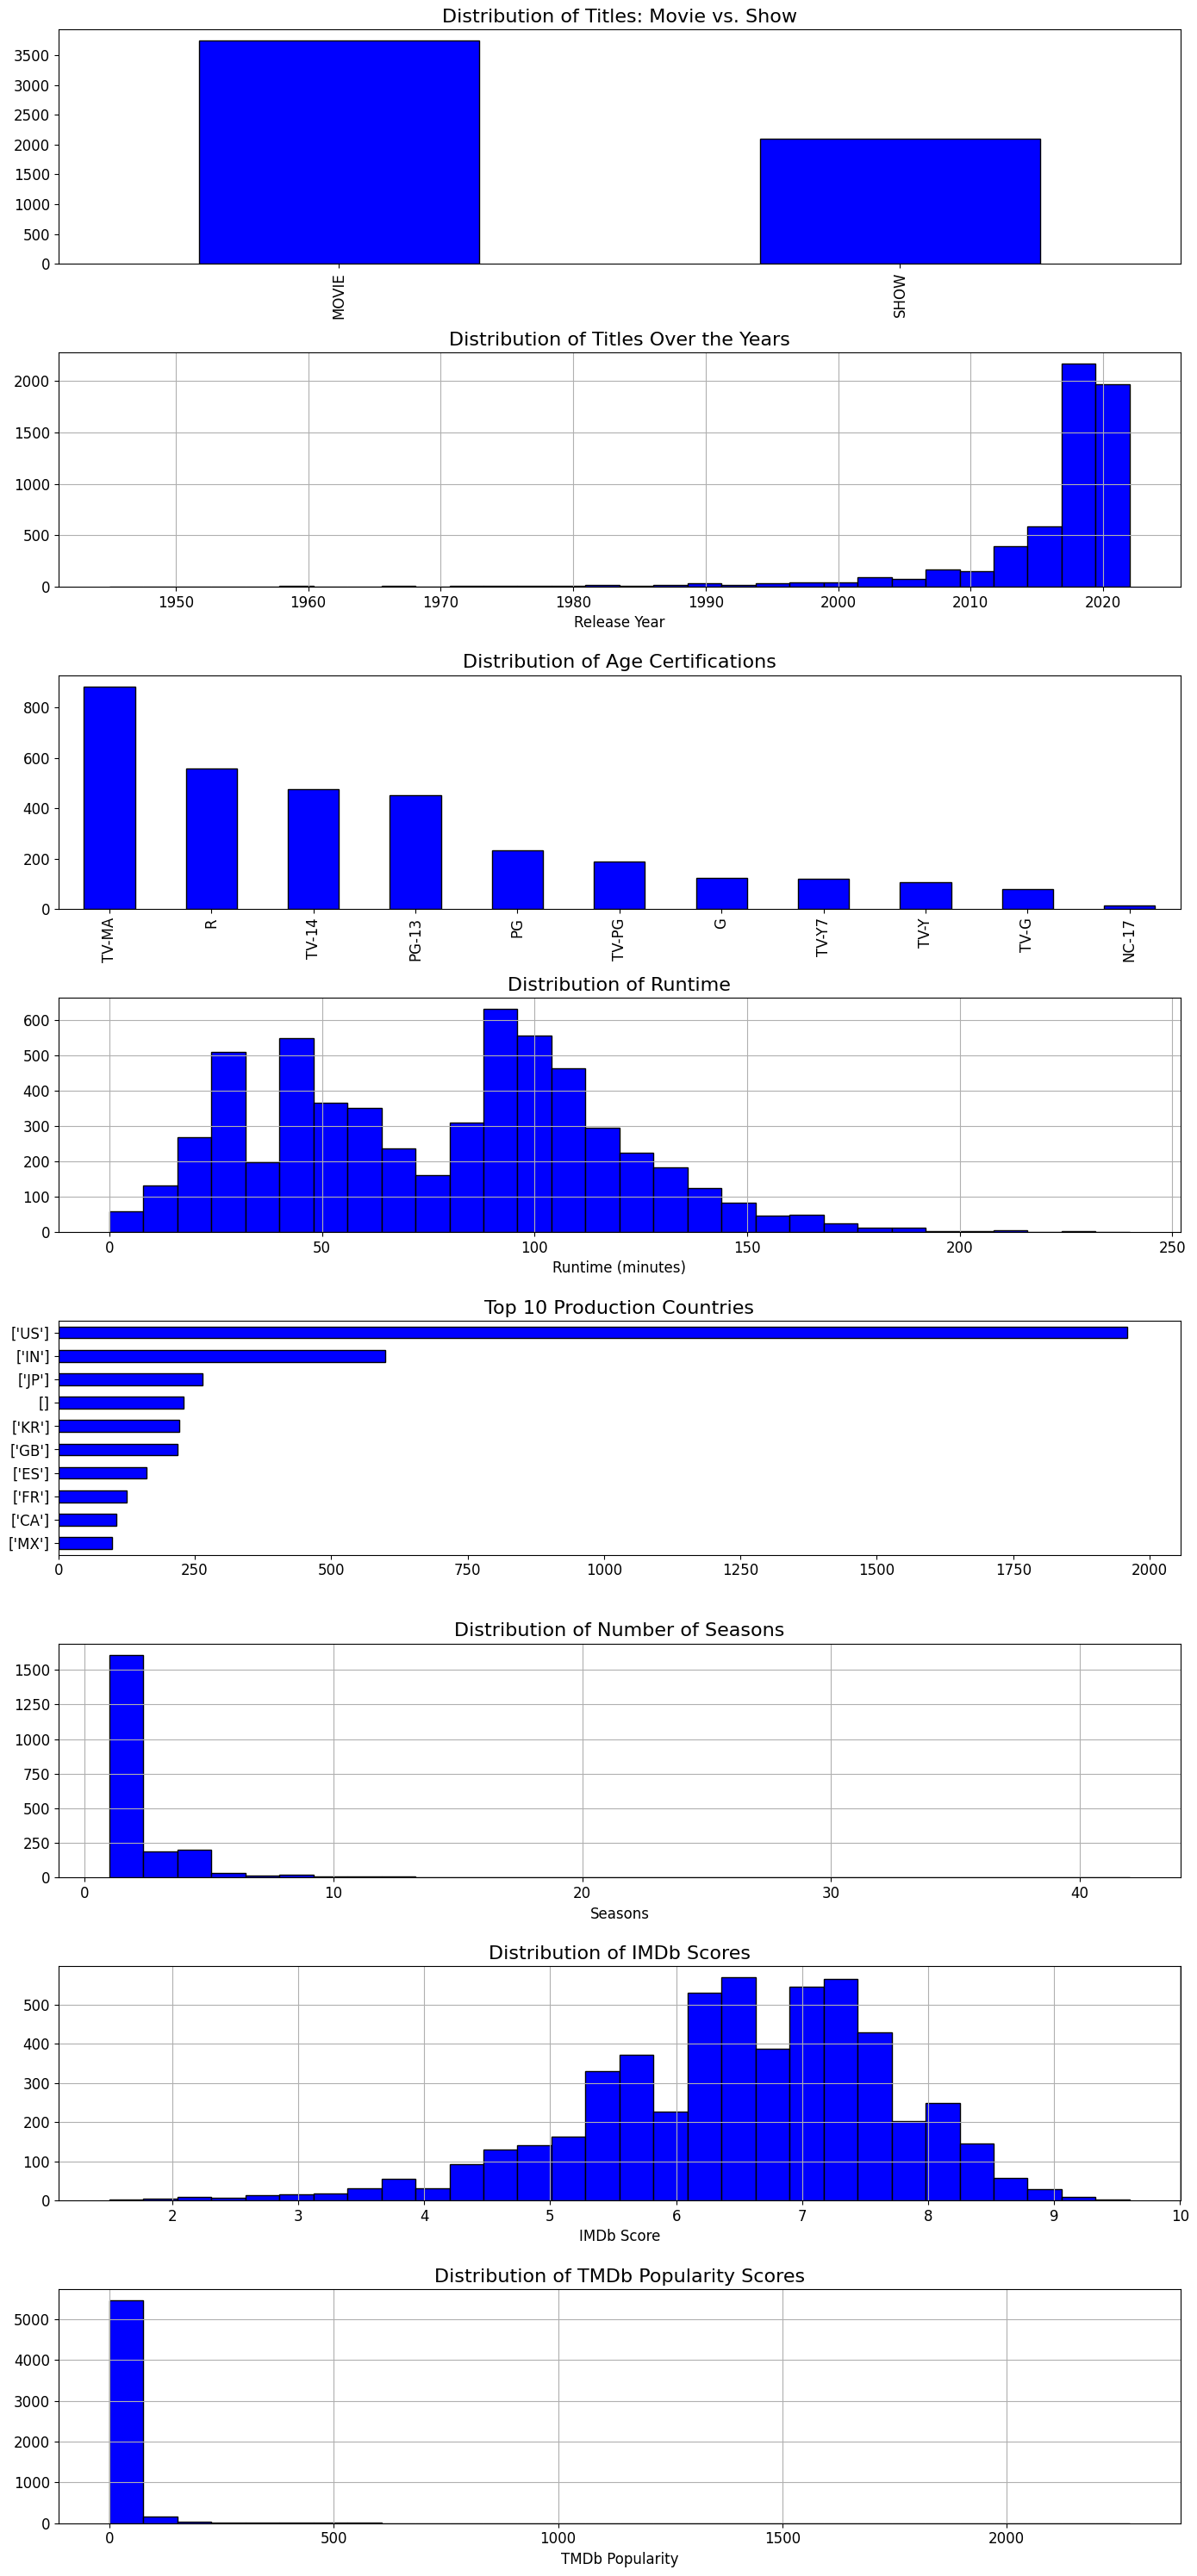

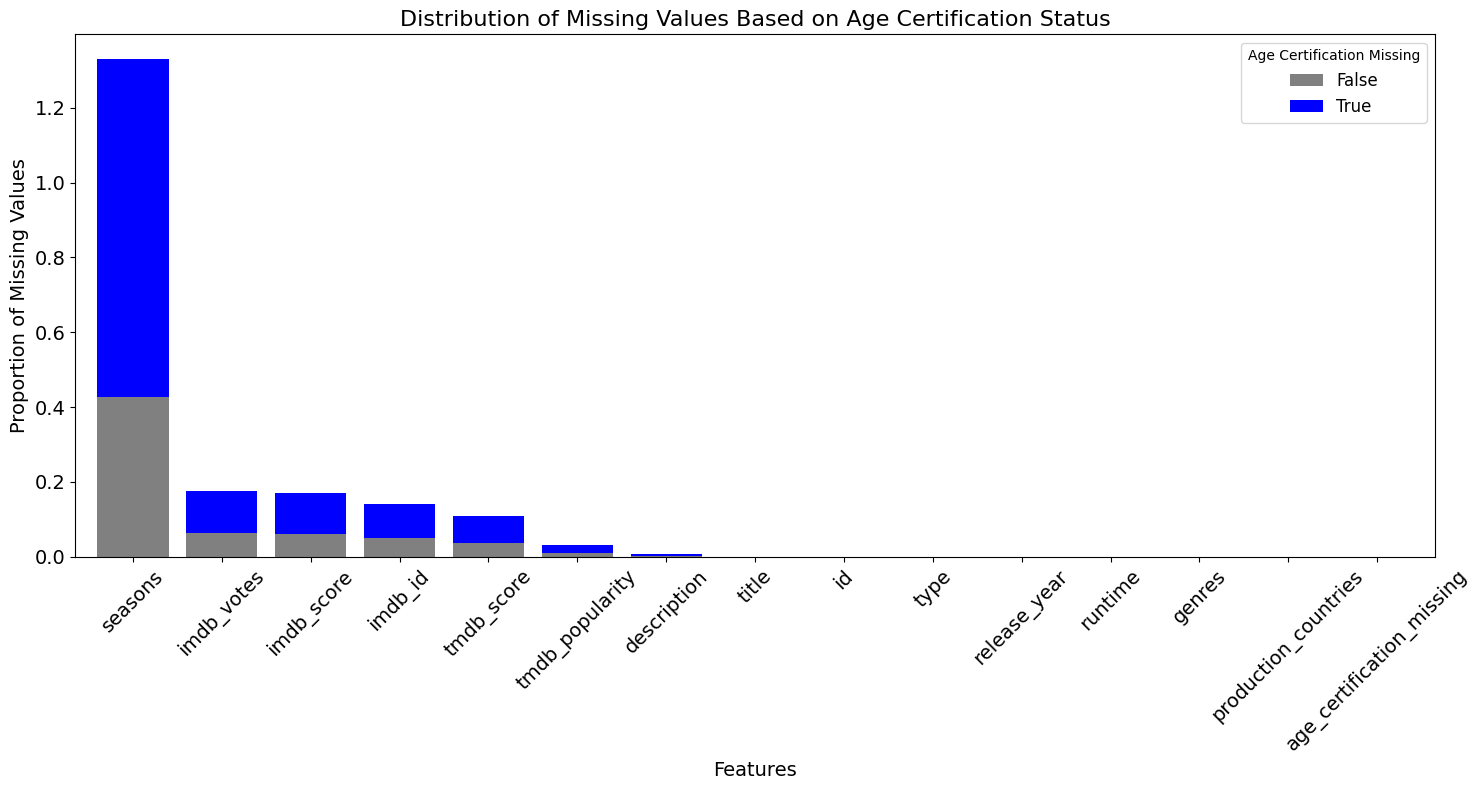

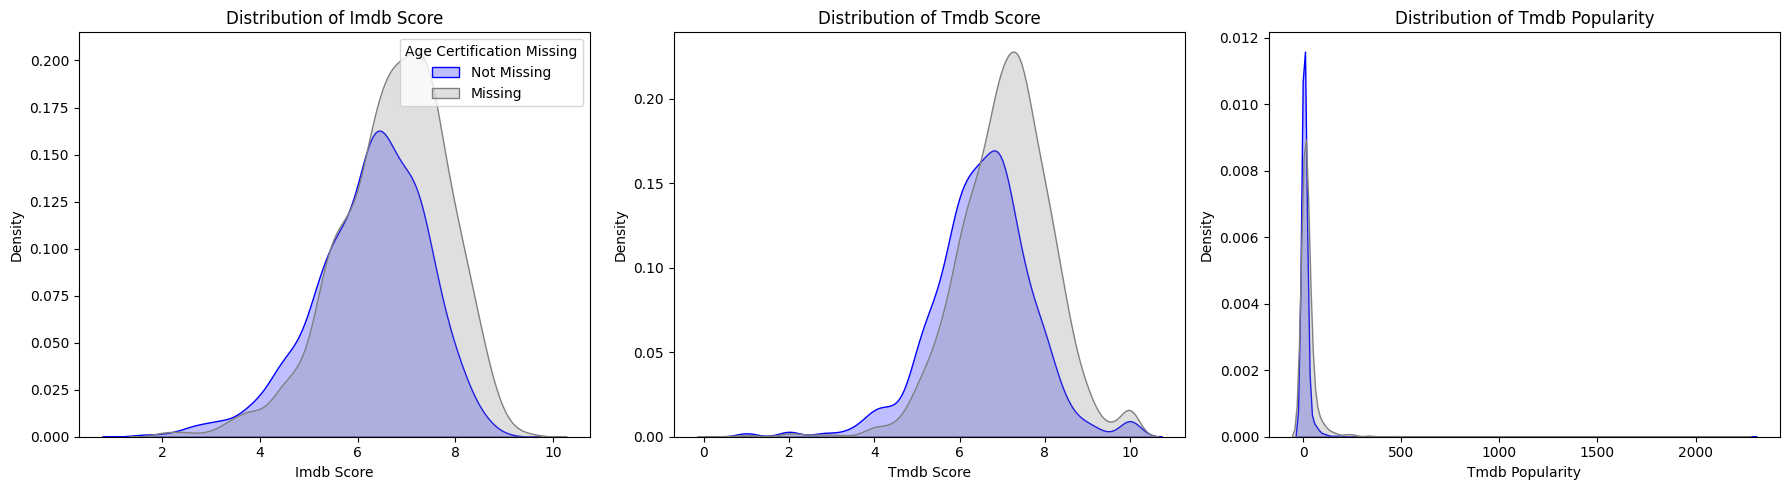

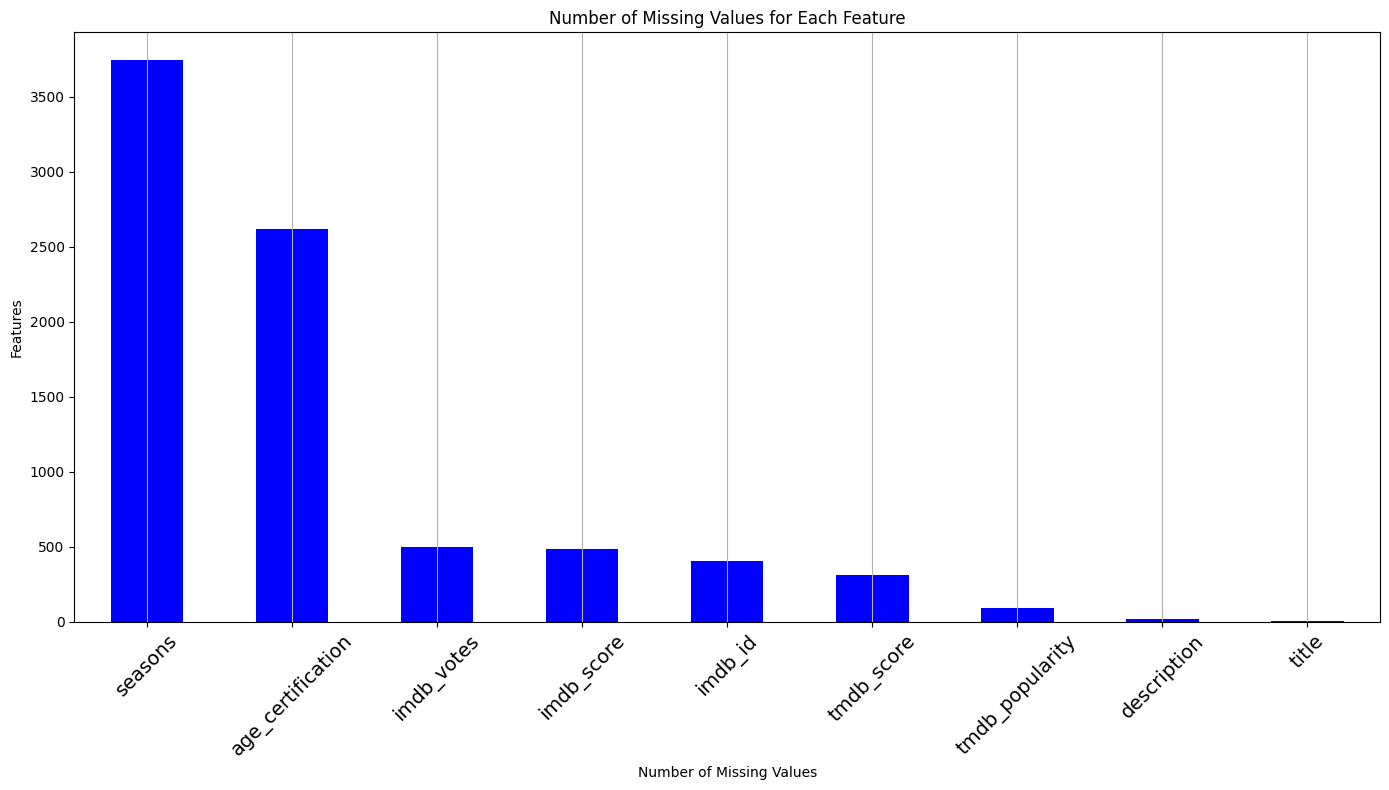

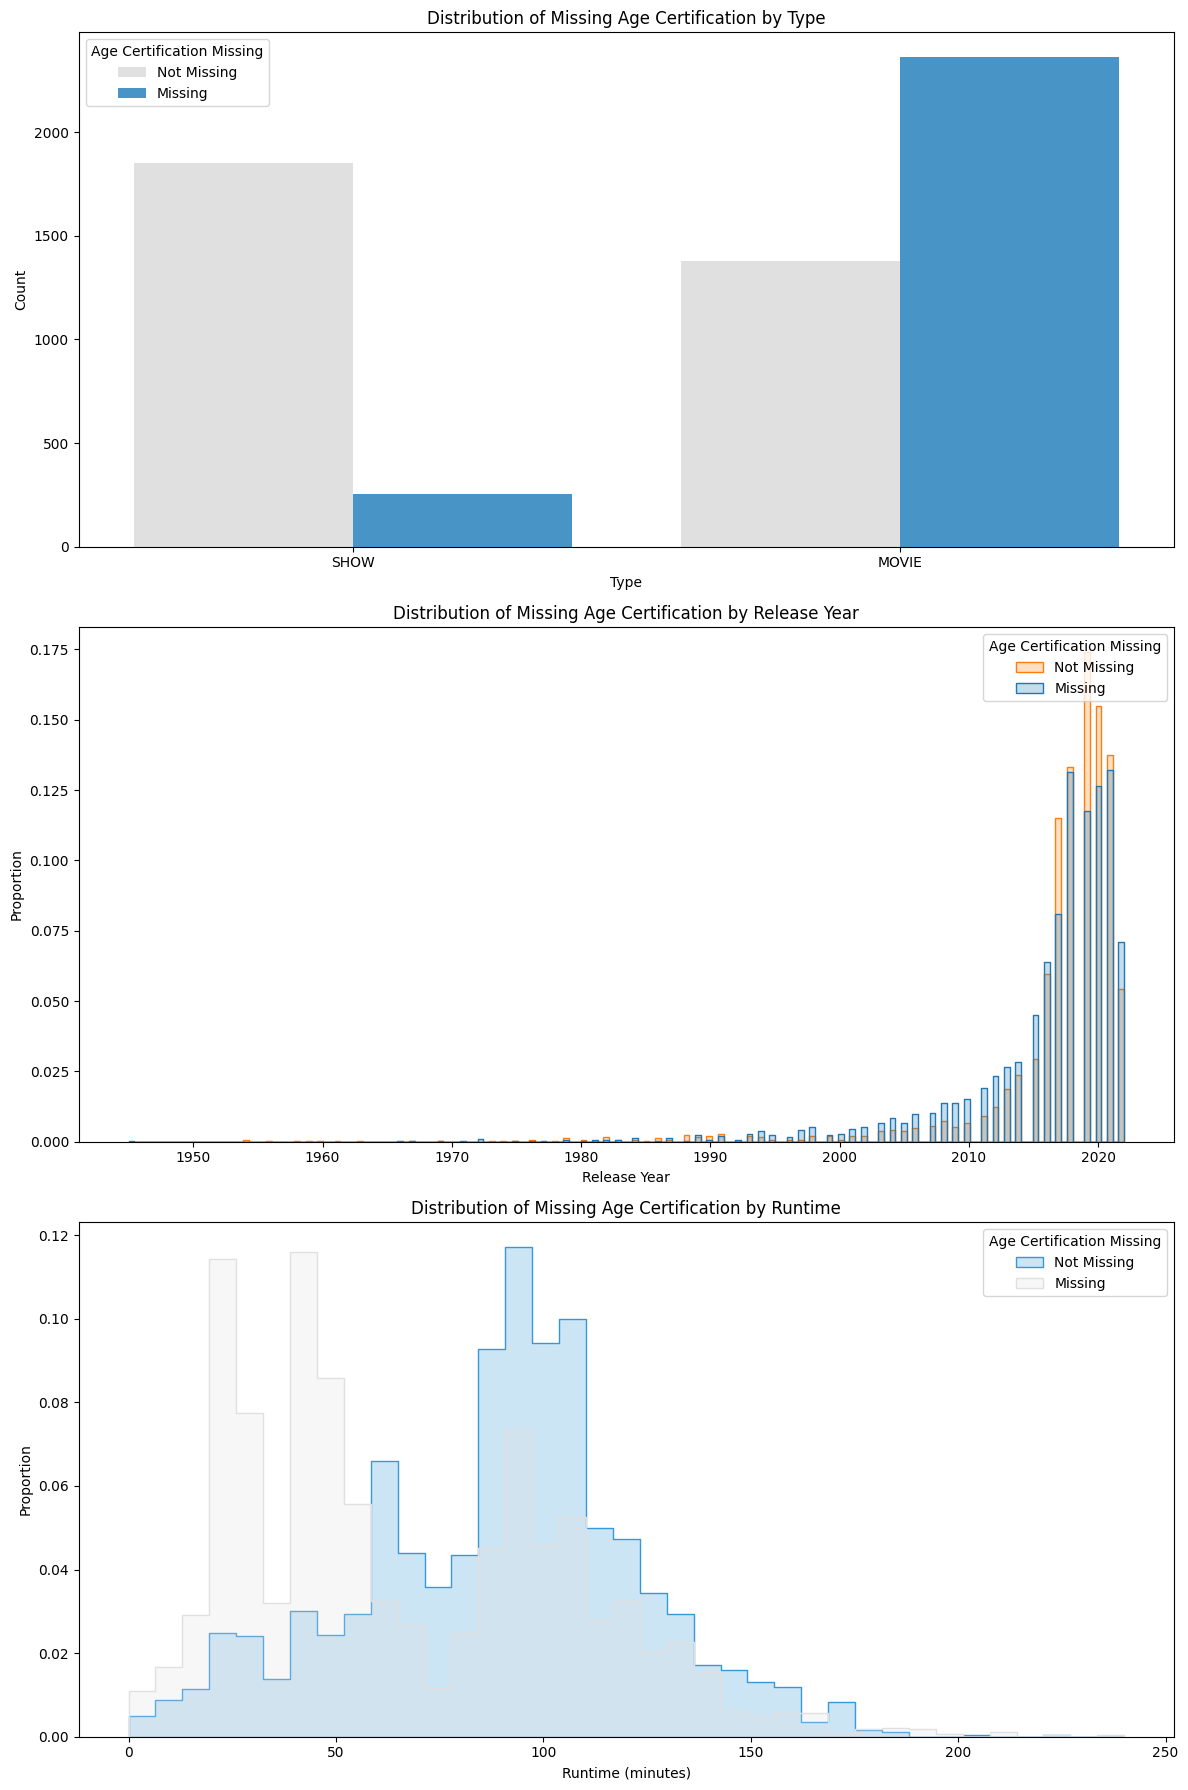

In [39]:
titles = pd.read_csv('titles.csv')
# Set up the figure and axes
fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(14, 30))

# 1. title: Displaying the first few titles
first_titles = titles['title'].head()
print("First few titles:")
print(first_titles)
print("\n")

# 2. type: Distribution of titles (Movie vs. Show)
titles['type'].value_counts().plot(kind='bar', ax=ax[0], color='blue', edgecolor='black')
ax[0].set_title('Distribution of Titles: Movie vs. Show', fontsize=16)
ax[0].tick_params(labelsize=12)

# 4. release_year: Distribution of titles over the years
titles['release_year'].hist(bins=30, ax=ax[1], color='blue', edgecolor='black')
ax[1].set_title('Distribution of Titles Over the Years', fontsize=16)
ax[1].set_xlabel('Release Year', fontsize=12)
ax[1].tick_params(labelsize=12)

# 5. age_certification: Distribution of age certifications
titles['age_certification'].value_counts().plot(kind='bar', ax=ax[2], color='blue', edgecolor='black')
ax[2].set_title('Distribution of Age Certifications', fontsize=16)
ax[2].tick_params(labelsize=12)

# 6. runtime: Distribution of runtime
titles['runtime'].hist(bins=30, ax=ax[3], color='blue', edgecolor='black')
ax[3].set_title('Distribution of Runtime', fontsize=16)
ax[3].set_xlabel('Runtime (minutes)', fontsize=12)
ax[3].tick_params(labelsize=12)

# 8. production_countries: Most common production countries (top 10)
titles['production_countries'].value_counts().head(10).plot(kind='barh', ax=ax[4], color='blue', edgecolor='black')
ax[4].set_title('Top 10 Production Countries', fontsize=16)
ax[4].invert_yaxis()
ax[4].tick_params(labelsize=12)

# 9. seasons: Distribution of number of seasons
titles['seasons'].hist(bins=30, ax=ax[5], color='blue', edgecolor='black')
ax[5].set_title('Distribution of Number of Seasons', fontsize=16)
ax[5].set_xlabel('Seasons', fontsize=12)
ax[5].tick_params(labelsize=12)

# 11. imdb_score: Distribution of IMDb scores
titles['imdb_score'].hist(bins=30, ax=ax[6], color='blue', edgecolor='black')
ax[6].set_title('Distribution of IMDb Scores', fontsize=16)
ax[6].set_xlabel('IMDb Score', fontsize=12)
ax[6].tick_params(labelsize=12)

# 13. tmdb_popularity: Distribution of TMDb popularity scores
titles['tmdb_popularity'].hist(bins=30, ax=ax[7], color='blue', edgecolor='black')
ax[7].set_title('Distribution of TMDb Popularity Scores', fontsize=16)
ax[7].set_xlabel('TMDb Popularity', fontsize=12)
ax[7].tick_params(labelsize=12)

plt.tight_layout()
plt.show()

titles_df = titles.copy()
# Create a new column indicating whether age_certification is missing or not
titles_df['age_certification_missing'] = titles_df['age_certification'].isnull()

# Plot the distribution of missing values in other features based on age_certification status
missing_values_distribution = titles_df.groupby('age_certification_missing').apply(lambda x: x.isnull().mean()).drop('age_certification', axis=1).T
missing_values_distribution = missing_values_distribution.sort_values(by=True, ascending=False)

# Plotting
plt.figure(figsize=(15, 10))
missing_values_distribution.plot(kind='bar', stacked=True, figsize=(15, 8), color=['gray', 'blue'], width=0.8, ax=plt.gca())
plt.title('Distribution of Missing Values Based on Age Certification Status', fontsize=16)
plt.ylabel('Proportion of Missing Values', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Age Certification Missing', fontsize=12)

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))
features_to_plot = ['imdb_score', 'tmdb_score', 'tmdb_popularity']
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(data=titles_df, x=feature, hue='age_certification_missing', fill=True, palette=['gray', 'blue'])
    plt.title(f'Distribution of {feature.replace("_", " ").title()}')
    plt.xlabel(f'{feature.replace("_", " ").title()}')
    plt.ylabel('Density')
    if i == 1:
        plt.legend(title='Age Certification Missing', labels=['Not Missing', 'Missing'])
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()

missing_values = titles_df.isnull().sum()
# Plotting the bar chart for missing values
plt.figure(figsize=(14, 8))
missing_values[missing_values > 0].sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Number of Missing Values for Each Feature')
plt.xlabel('Number of Missing Values')
plt.xticks(rotation=45, fontsize=14)
plt.ylabel('Features')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

titles_df['age_cert_missing'] = titles_df['age_certification'].isnull().astype(int)
# Set up a grid of plots with blue color theme
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# Distribution of Missingness by Type
sns.countplot(data=titles_df, x='type', hue='age_cert_missing', ax=axes[0], palette=["#E0E0E0", "#3498db"])
axes[0].set_title('Distribution of Missing Age Certification by Type')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Count')
axes[0].legend(title='Age Certification Missing', labels=['Not Missing', 'Missing'])

# Distribution of Missingness by Release Year
sns.histplot(data=titles_df, x='release_year', hue='age_cert_missing', element='step', stat='probability', common_norm=False, ax=axes[1])
axes[1].set_title('Distribution of Missing Age Certification by Release Year')
axes[1].set_xlabel('Release Year')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Age Certification Missing', labels=['Not Missing', 'Missing'])

# Distribution of Missingness by Runtime
sns.histplot(data=titles_df, x='runtime', hue='age_cert_missing', element='step', stat='probability', common_norm=False, palette=["#E0E0E0", "#3498db"], ax=axes[2])
axes[2].set_title('Distribution of Missing Age Certification by Runtime')
axes[2].set_xlabel('Runtime (minutes)')
axes[2].set_ylabel('Proportion')
axes[2].legend(title='Age Certification Missing', labels=['Not Missing', 'Missing'])

plt.tight_layout()
plt.show()

# Data Preprocessing

## Split dataset into Movies and TV Shows and Remove Empty Cells

In [40]:
# Split dataset into Movies and TV Shows
movies = titles[titles["type"] == "MOVIE"]
tv_shows = titles[titles["type"] == "SHOW"]

# Remove rows with empty values
columns_to_remove = ['age_certification', 'description', 'production_countries', 'genres',
                    'imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score']
movies = movies.dropna(subset=columns_to_remove)
tv_shows = tv_shows.dropna(subset=columns_to_remove)

# Remove empty lists in production_countries
movies = movies[movies['production_countries'] != '[]']
tv_shows = tv_shows[tv_shows['production_countries'] != '[]']

# Remove redundant seasons column from movies dataset
movies = movies.drop("seasons", axis=1)

movies["production_countries"] = movies["production_countries"].apply(ast.literal_eval)
tv_shows["production_countries"] = tv_shows["production_countries"].apply(ast.literal_eval)

movies["genres"] = movies["genres"].apply(ast.literal_eval)
tv_shows["genres"] = tv_shows["genres"].apply(ast.literal_eval)

## Casefold, Remove non-alphabetic characters, Tokenize


In [41]:
def preprocess_description(desc):

  # Convert description to lower case
  lowercased_desc = desc.lower()

  # Remove non-alphabetic characters
  no_punct = re.sub(r'[^A-Za-z\s]', '', lowercased_desc)

  # Tokenize each description
  tokens = nltk.word_tokenize(no_punct)

  # Remove stopwords
  tokens = [w for w in tokens if not w in stop_words]

  # Lemmatize
  lemmatized = [lemmatizer.lemmatize(w) for w in tokens]

  return lemmatized

movies["Description Words"] = movies["description"].apply(preprocess_description)
tv_shows["Description Words"] = tv_shows["description"].apply(preprocess_description)

movies["Title Words"] = movies["title"].apply(preprocess_description)
tv_shows["Title Words"] = tv_shows["title"].apply(preprocess_description)

## Encoding

In [42]:
# Encoding Age Certifications
label_encoder = LabelEncoder()
movies["age_certification_encoded"] = label_encoder.fit_transform(movies["age_certification"])
tv_shows["age_certification_encoded"] = label_encoder.fit_transform(tv_shows["age_certification"])

# One-Hot Encoding Genres and Production Countries Column
mlb = MultiLabelBinarizer()

encoded_movie_genres = mlb.fit_transform(movies["genres"])
df_encoded_movie_genres = pd.DataFrame(encoded_movie_genres, columns=mlb.classes_, index=movies.index)
encoded_tvshows_genres = mlb.fit_transform(tv_shows["genres"])
df_encoded_tvshows_genres = pd.DataFrame(encoded_tvshows_genres, columns=mlb.classes_, index=tv_shows.index)

encoded_movie_countries = mlb.fit_transform(movies["production_countries"])
df_encoded_movie_countries = pd.DataFrame(encoded_movie_countries, columns=mlb.classes_, index=movies.index)
encoded_tvshows_countries = mlb.fit_transform(tv_shows["production_countries"])
df_encoded_tvshows_countries = pd.DataFrame(encoded_tvshows_countries, columns=mlb.classes_, index=tv_shows.index)


# Merge One-Hot Encoded with Movies and TV Shows Dataset
movies = pd.concat([movies, df_encoded_movie_genres, df_encoded_movie_countries], axis=1)
tv_shows = pd.concat([tv_shows, df_encoded_tvshows_genres, df_encoded_tvshows_countries], axis=1)

## Visualising Skewness of IMDB Votes and Log Transforming

## Movies

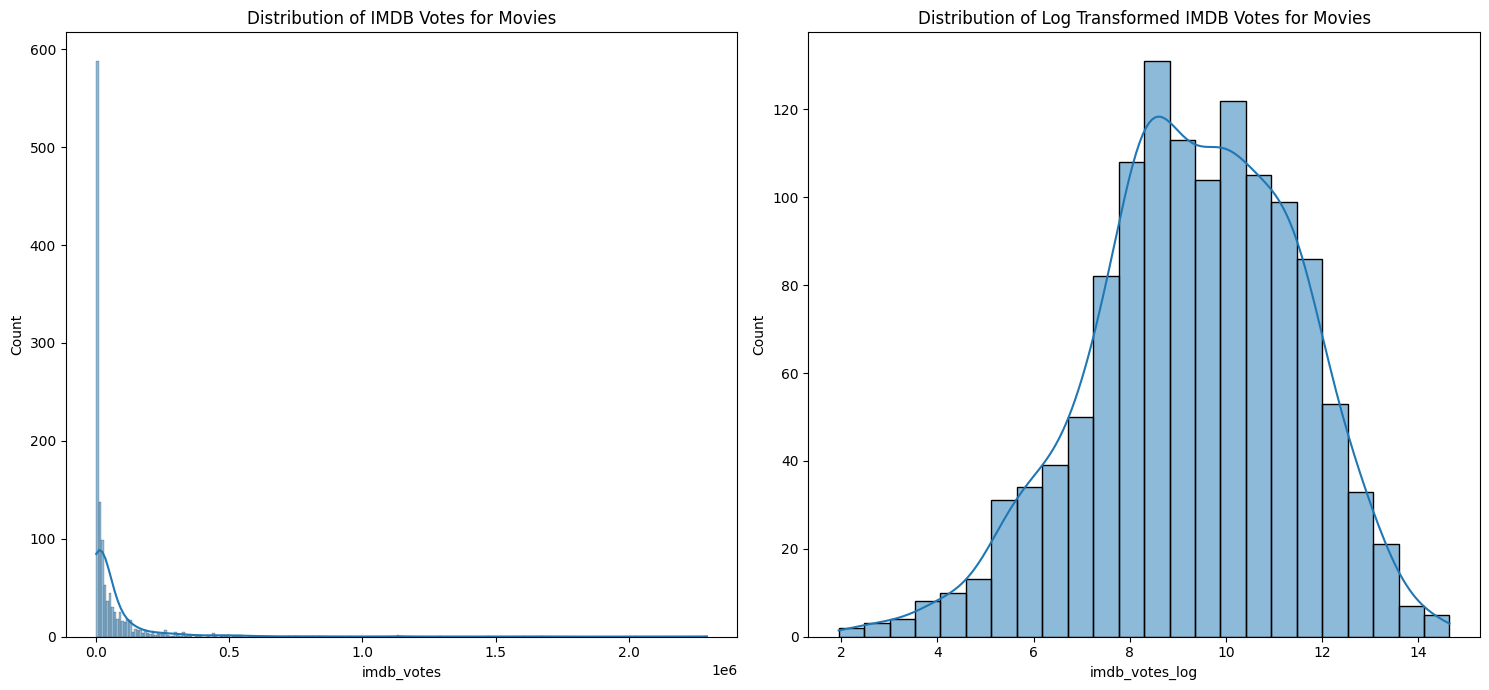

In [43]:
# Create Histogram for IMDB Votes Before and After Log Transform
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.histplot(movies['imdb_votes'], kde=True)
plt.title('Distribution of IMDB Votes for Movies')

# Log transform IMDB Votes
movies['imdb_votes_log'] = np.log1p(movies['imdb_votes'])

plt.subplot(1, 2, 2)
sns.histplot(movies['imdb_votes_log'], kde=True)
plt.title('Distribution of Log Transformed IMDB Votes for Movies')

plt.tight_layout()

## TV Shows

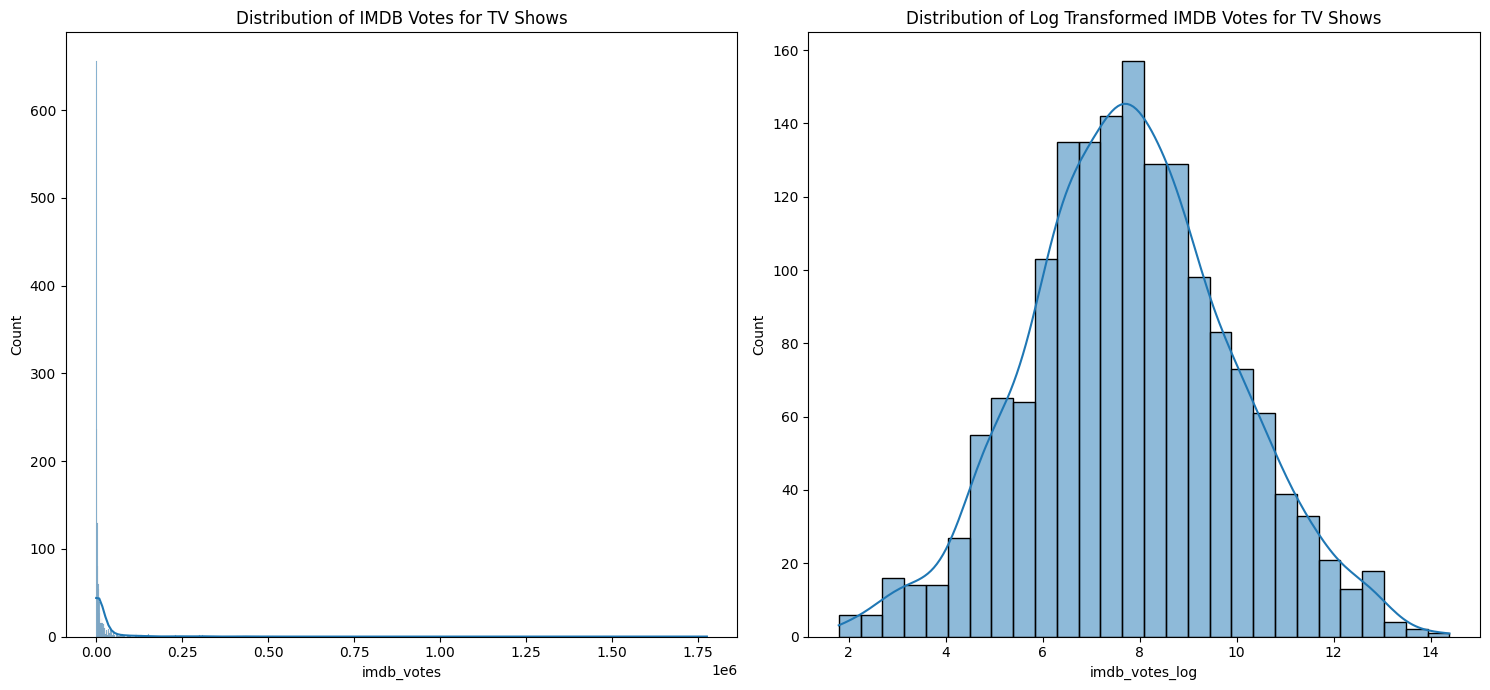

In [44]:
# Create Histogram for IMDB Votes Before and After Log Transform
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.histplot(tv_shows['imdb_votes'], kde=True)
plt.title('Distribution of IMDB Votes for TV Shows')

# Log transform IMDB Votes
tv_shows['imdb_votes_log'] = np.log1p(tv_shows['imdb_votes'])

plt.subplot(1, 2, 2)
sns.histplot(tv_shows['imdb_votes_log'], kde=True)
plt.title('Distribution of Log Transformed IMDB Votes for TV Shows')

plt.tight_layout()

## Visualising Skewness of TMDB Popularity and Log Transforming

## Movies

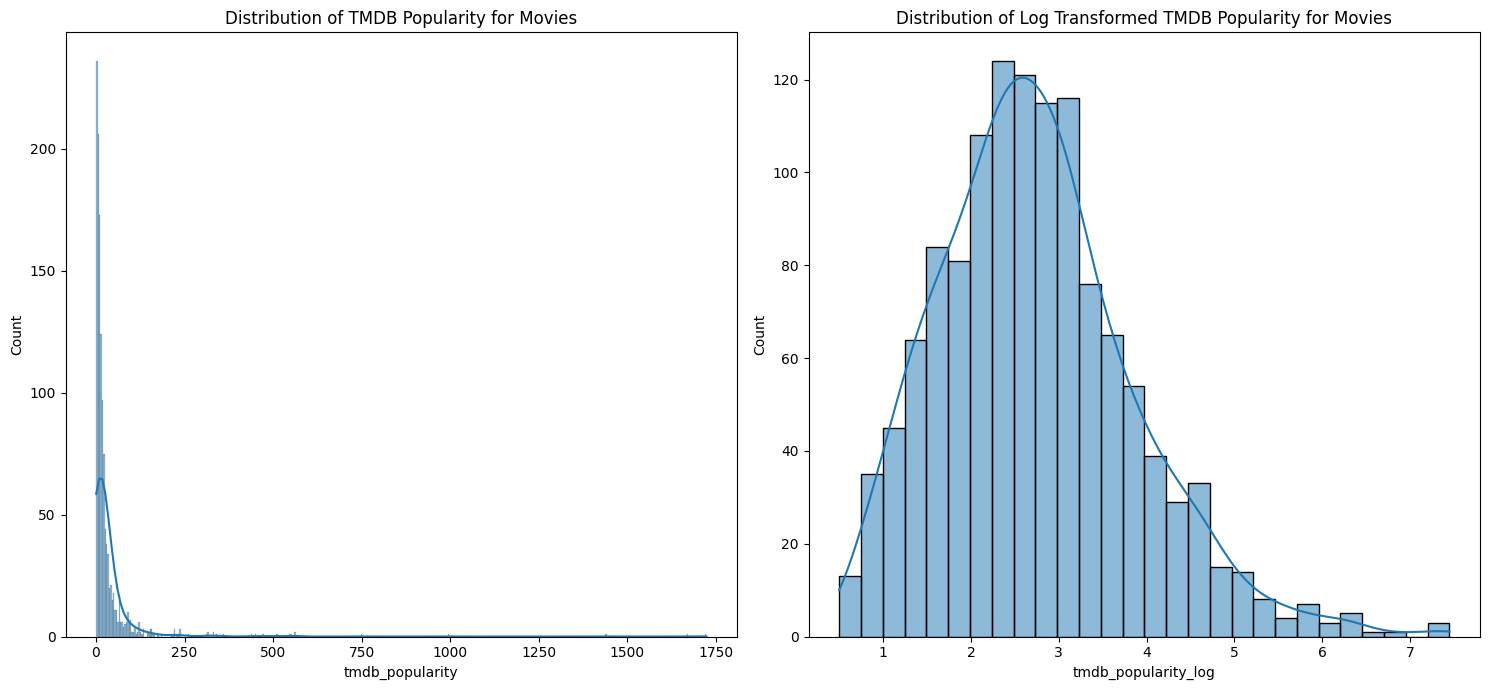

In [45]:
# Create Histogram for IMDB Popularity Before and After Log Transform
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.histplot(movies['tmdb_popularity'], kde=True)
plt.title('Distribution of TMDB Popularity for Movies')

# Log transform IMDB Votes
movies['tmdb_popularity_log'] = np.log1p(movies['tmdb_popularity'])

plt.subplot(1, 2, 2)
sns.histplot(movies['tmdb_popularity_log'], kde=True)
plt.title('Distribution of Log Transformed TMDB Popularity for Movies')

plt.tight_layout()
plt.savefig('imdb_votes_distribution.png')

## TV Shows

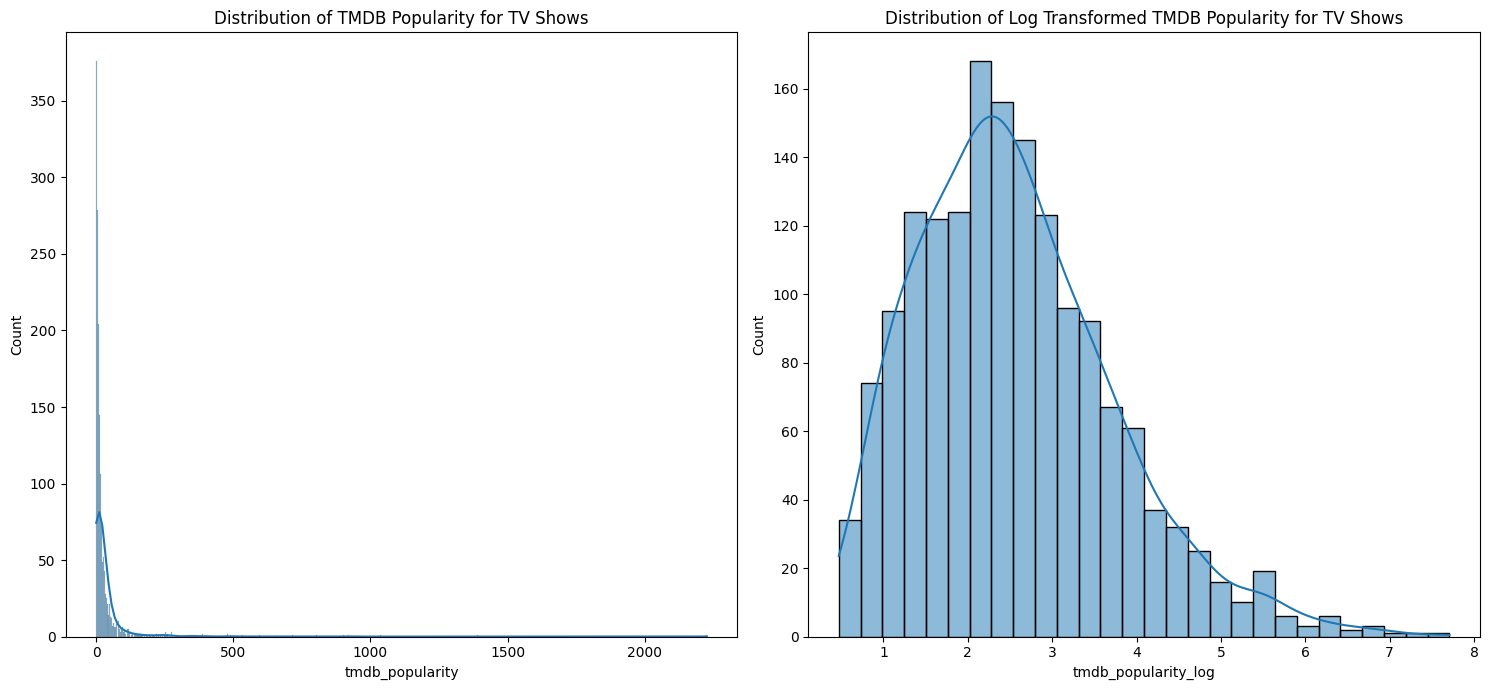

In [46]:
# Create Histogram for IMDB Popularity Before and After Log Transform
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
sns.histplot(tv_shows['tmdb_popularity'], kde=True)
plt.title('Distribution of TMDB Popularity for TV Shows')

# Log transform IMDB Votes
tv_shows['tmdb_popularity_log'] = np.log1p(tv_shows['tmdb_popularity'])

plt.subplot(1, 2, 2)
sns.histplot(tv_shows['tmdb_popularity_log'], kde=True)
plt.title('Distribution of Log Transformed TMDB Popularity for TV Shows')

plt.tight_layout()
plt.savefig('tmdb_popularity_distribution.png')

## Discretization

In [47]:
# Discretize Log Transformed IMDB Votes
equal_width = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
movies["binned_imdb_votes"] = equal_width.fit_transform(movies["imdb_votes_log"].values.reshape(-1, 1))
tv_shows["binned_imdb_votes"] = equal_width.fit_transform(tv_shows["imdb_votes_log"].values.reshape(-1, 1))

# Discretize Runtime using Domain Knowledge

# Define custom bins for 'runtime' with the extra bin
bins_runtime = [0, 30, 60, 90, 120, 200]

# Create labels for the bins
bin_labels_runtime = ['<30', '30-60', '60-90', '90-120', '120-200']

movies['binned_runtime'] = pd.cut(movies['runtime'], bins=bins_runtime, labels=bin_labels_runtime, right=False)
tv_shows['binned_runtime'] = pd.cut(tv_shows['runtime'], bins=bins_runtime, labels=bin_labels_runtime, right=False)

# Encoding binned runtime
movies['binned_runtime_encoded'] = label_encoder.fit_transform(movies['binned_runtime'])
tv_shows['binned_runtime_encoded'] = label_encoder.fit_transform(tv_shows['binned_runtime'])

# Discretize Release Year

# Define custom bins for 'release_year'
bins_release_year = [0, 1980, 1990, 2000, 2010, 2015, 2020, 3000]  # Custom bin edges

# Create labels for the bins
bin_labels_release_year = ['<1980', '1980-1990', '1990-2000', '2000-2010', '2010-2015', '2015-2020', '>2020']

# Discretize 'release_year' into categorical bins and overwrite the original column
movies['binned_release_year'] = pd.cut(movies['release_year'], bins=bins_release_year, labels=bin_labels_release_year, right=False)
tv_shows['binned_release_year'] = pd.cut(tv_shows['release_year'], bins=bins_release_year, labels=bin_labels_release_year, right=False)

# Encoding binned release year
movies['binned_release_year_encoded'] = label_encoder.fit_transform(movies['binned_release_year'])
tv_shows['binned_release_year_encoded'] = label_encoder.fit_transform(tv_shows['binned_release_year'])

# Discretize IMDB Score and TMDB Score
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Fit and transform the 'imdb_score' column in the new dataset
movies['binned_imdb_score'] = est.fit_transform(movies[['imdb_score']])
tv_shows["binned_imdb_score"] = est.fit_transform(tv_shows[['imdb_score']])

# Fit and transform the 'tmdb_score' column in the new dataset
movies['binned_tmdb_score'] = est.fit_transform(movies[['tmdb_score']])
tv_shows["binned_tmdb_score"] = est.fit_transform(tv_shows[['tmdb_score']])

# Discretize Log Transformed TMDB Popularity
movies["binned_tmdb_popularity"] = equal_width.fit_transform(movies["tmdb_popularity_log"].values.reshape(-1, 1))
tv_shows["binned_tmdb_popularity"] = equal_width.fit_transform(tv_shows["tmdb_popularity_log"].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:2

# Visualisation

## Distribution of runtime for Movies and TV Shows

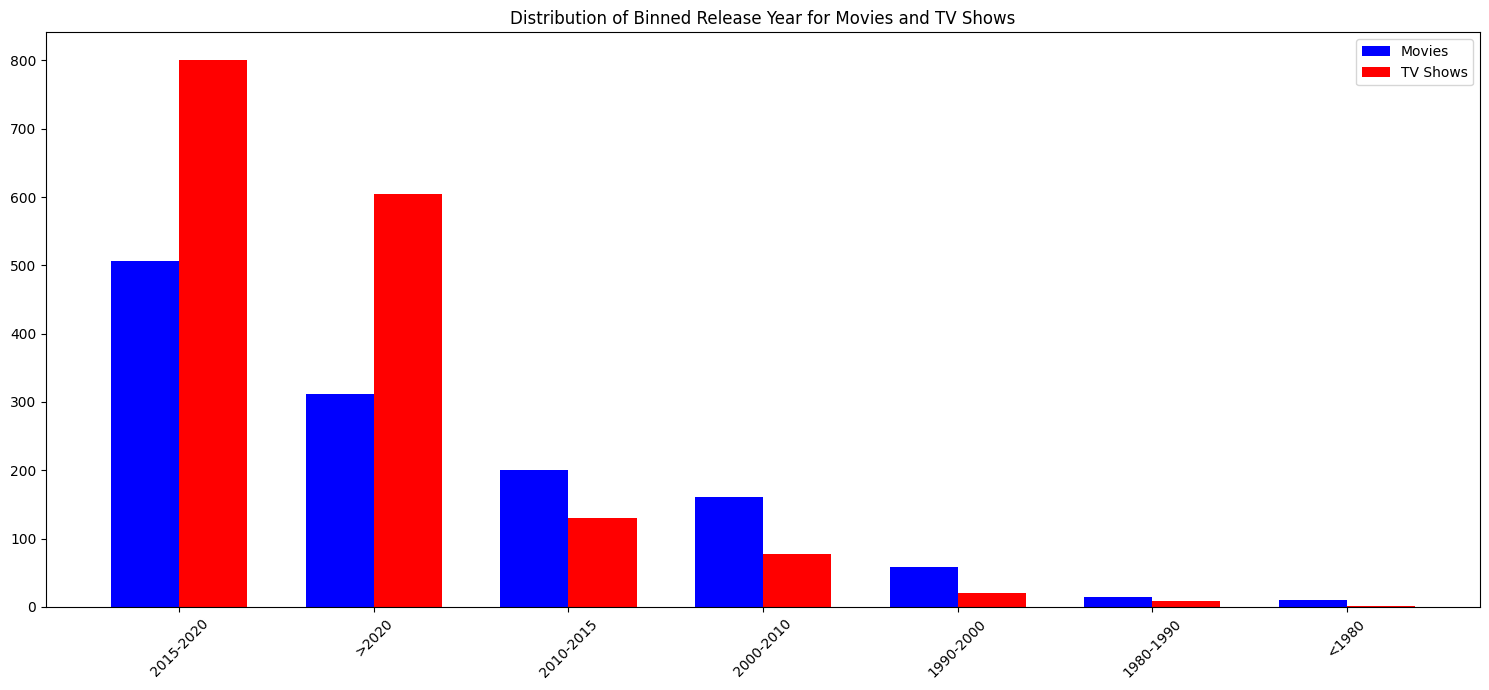

In [48]:
# Calculate the count of each binned_runtime for movies and tv shows
movies_runtime_count = movies['binned_release_year'].value_counts()
tv_shows_runtime_count = tv_shows['binned_release_year'].value_counts()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 7))

# Bar width
width = 0.35

# Bar positions
ind = range(len(movies_runtime_count))

# Plotting
bar1 = ax.bar(ind, movies_runtime_count.values, width, label='Movies', color='b')
bar2 = ax.bar([i + width for i in ind], tv_shows_runtime_count.reindex(movies_runtime_count.index).fillna(0).values, width, label='TV Shows', color='r')

# Set the title and labels
ax.set_title('Distribution of Binned Release Year for Movies and TV Shows')
ax.set_xticks([i + width / 2 for i in ind])
ax.set_xticklabels(movies_runtime_count.index)
ax.legend()

# Rotate x labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('movies_tvshows_release_year_distribution.png')
plt.show()

## Word Cloud for Each Movie Age Certification Based on Description

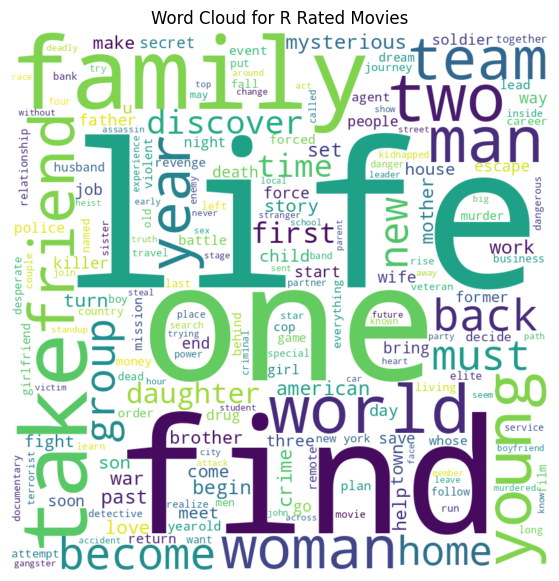

<Figure size 640x480 with 0 Axes>

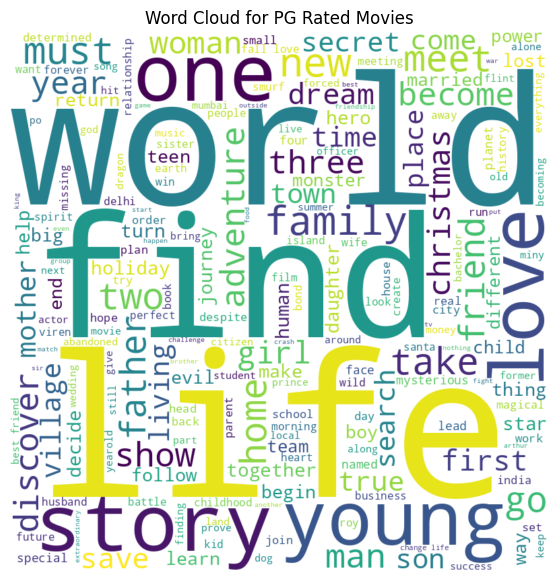

<Figure size 640x480 with 0 Axes>

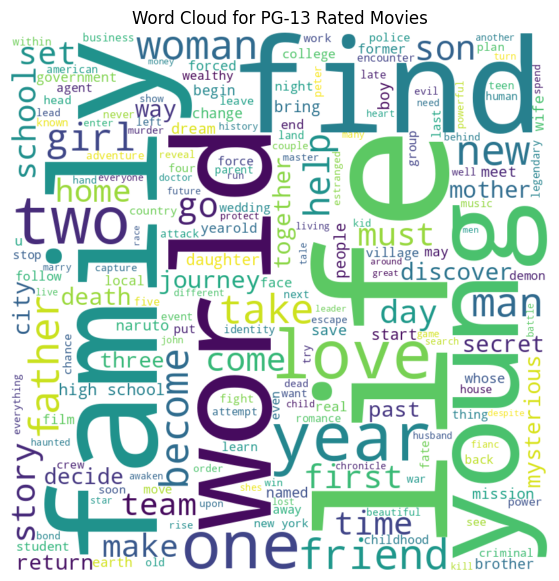

<Figure size 640x480 with 0 Axes>

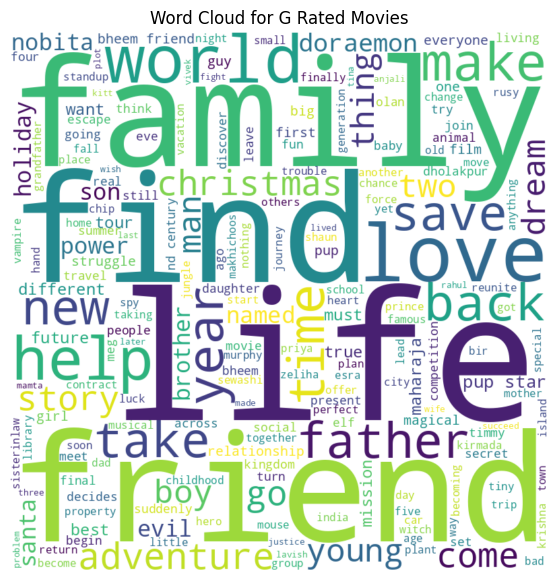

<Figure size 640x480 with 0 Axes>

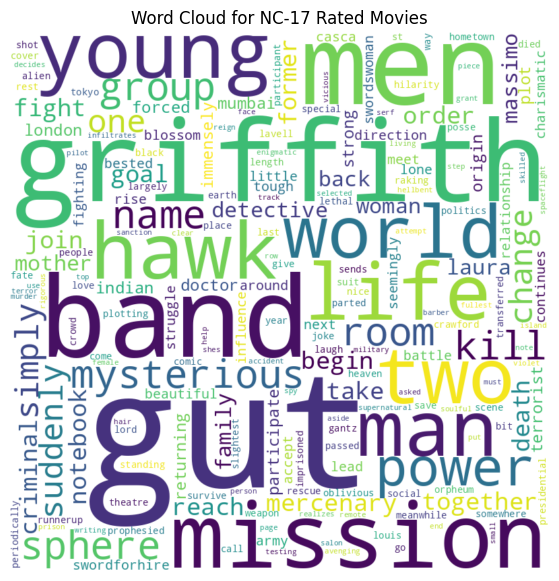

<Figure size 640x480 with 0 Axes>

In [49]:
age_certifications_movies = movies["age_certification"].unique()
for age_cert in age_certifications_movies:
  subgroup = movies[movies["age_certification"] == age_cert]

  all_words = []
  for words in subgroup["Description Words"].tolist():
    for word in words:
      all_words.append(word)

  all_descriptions = " ".join(all_words)

  wordcloud = WordCloud(width=800, height=800,
                        background_color="white").generate(all_descriptions)
  plt.figure(figsize=(15,7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Word Cloud for {age_cert} Rated Movies")
  plt.show()
  plt.savefig(f'wordcloud_{age_cert}.png', bbox_inches='tight')
  print("\n")

## Word Cloud for Each TV Show Age Certification Based on Description

In [50]:
age_certifications_tv_shows = tv_shows["age_certification"].unique()
for age_cert in age_certifications_tv_shows:
  subgroup = tv_shows[tv_shows["age_certification"] == age_cert]

  all_words = []
  for words in subgroup["Description Words"].tolist():
    for word in words:
      all_words.append(word)

  all_descriptions = " ".join(all_words)

  wordcloud = WordCloud(width=800, height=800,
                        background_color="white").generate(all_descriptions)
  plt.figure(figsize=(15,7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Word Cloud for {age_cert} Rated TV Shows")
  plt.show()
  plt.savefig(f'wordcloud_{age_cert}.png', bbox_inches='tight')
  print("\n")

Output hidden; open in https://colab.research.google.com to view.

# Feature Selection

## Filter Out Irrelevant Columns

In [51]:
# Remove id, type and imdb_id column
movies = movies.drop(columns=["id", "type", "imdb_id"])
tv_shows = tv_shows.drop(columns=["id", "type", "imdb_id"])

movies.to_csv("movies.csv", index=False)
tv_shows.to_csv("tv_shows.csv", index=False)

# Calculating Mutual Information

## Movies

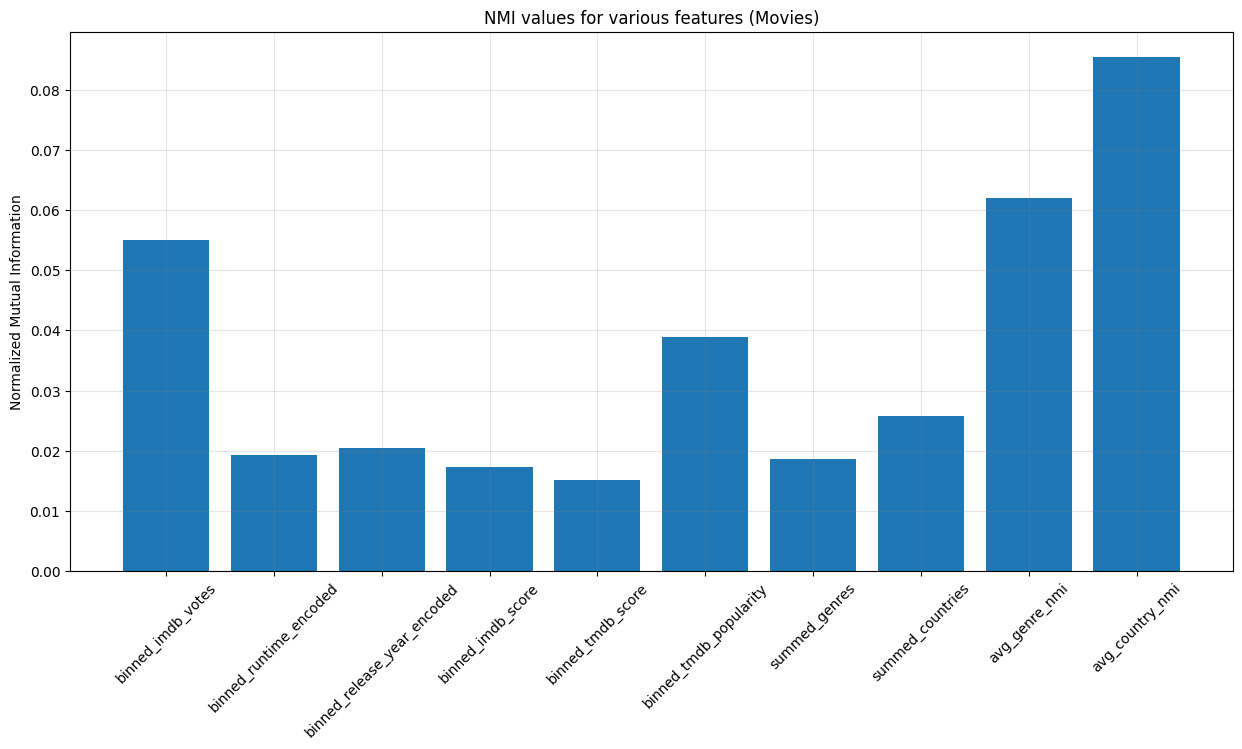

In [52]:
# Mutual Information for All Features with Age Certification
features = ["binned_imdb_votes", "binned_runtime_encoded", "binned_release_year_encoded", "binned_imdb_score", "binned_tmdb_score", "binned_tmdb_popularity"]

nmi_values= {}
for feature in features:
  nmi_values[feature] = NMI(movies['age_certification_encoded'], movies[feature], average_method='min')

# Calculate Normalized Mutual Information Score for the Sum of Individual Genres
genres = ["action", "animation", "comedy", "crime", "documentation", "drama", "european", "family",
          "fantasy", "history", "horror", "music", "reality", "romance", "scifi", "sport", "thriller", "war", "western"]
movies['summed_genres'] = movies[genres].sum(axis=1)
nmi_values['summed_genres'] = NMI(movies['age_certification_encoded'], movies['summed_genres'], average_method='min')

# Calculate Normalized Mutual Information Score for the Sum of Individual Production Countries
countries = ["AE", "AL", "AR", "AT", "AU", "BE", "BG", "BR", "CA", "CH", "CL", "CN", "CO", "CY",
             "CZ", "DE", "DK", "EG", "ES", "FR", "GB", "GH", "GR", "HK", "HU", "ID", "IE", "IL",
             "IN", "IR", "IS", "IT", "JO", "JP", "KH", "KR", "LB", "LT", "LU", "MC", "MT", "MU",
             "MX", "NG", "NL", "NO", "NZ", "PE", "PH", "PK", "PL", "PR", "PT", "QA", "RO", "RS",
             "RU", "SE", "SG", "SN", "TH", "TR", "TW", "UA", "US", "VA", "XX", "ZA", "ZW"]
movies['summed_countries'] = movies[countries].sum(axis=1)
nmi_values['summed_countries'] = NMI(movies['age_certification_encoded'], movies['summed_countries'], average_method='min')

# Calculate Average NMI for Genres
genre_nmi_values = [NMI(movies['age_certification_encoded'], movies[genre], average_method='min') for genre in genres]
nmi_values['avg_genre_nmi'] = np.mean(genre_nmi_values)

# Calculate Average NMI for Production Countries
country_nmi_values = [NMI(movies['age_certification_encoded'], movies[country], average_method='min') for country in countries]
nmi_values['avg_country_nmi'] = np.mean(country_nmi_values)

plt.figure(figsize=(15,7))
plt.bar(nmi_values.keys(), nmi_values.values())
plt.grid(True, alpha=0.2, c="gray")
plt.xticks(rotation=45)
plt.ylabel('Normalized Mutual Information')
plt.title('NMI values for various features (Movies)')
plt.savefig('nmi_movies.png')

# IMDB votes, TMDB Pop, genres, production countries

## TV Shows

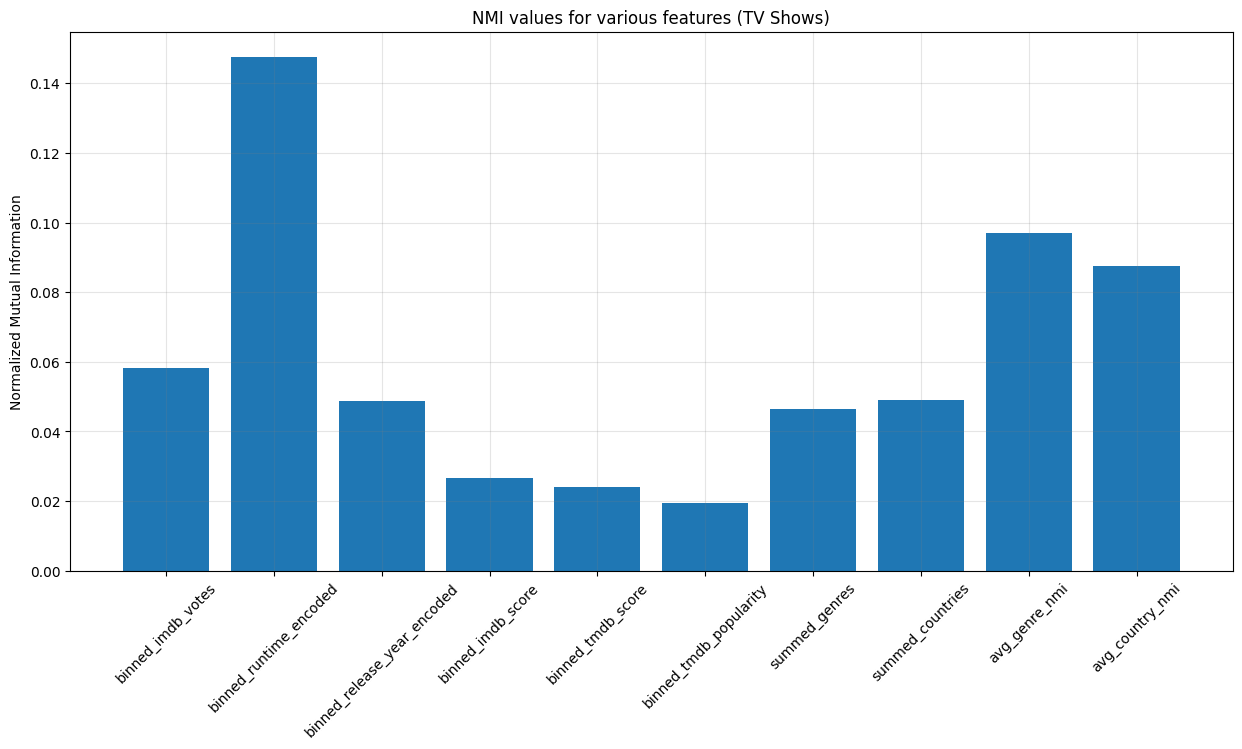

In [53]:
# Mutual Information for All Features with Age Certification
features = ["binned_imdb_votes", "binned_runtime_encoded", "binned_release_year_encoded", "binned_imdb_score", "binned_tmdb_score", "binned_tmdb_popularity"]

nmi_values= {}
for feature in features:
  nmi_values[feature] = NMI(tv_shows['age_certification_encoded'], tv_shows[feature], average_method='min')

# Calculate Normalized Mutual Information Score for the Sum of Individual Genres
genres = ["action", "animation", "comedy", "crime", "documentation", "drama", "european", "family",
          "fantasy", "history", "horror", "music", "reality", "romance", "scifi", "sport", "thriller", "war", "western"]
tv_shows['summed_genres'] = tv_shows[genres].sum(axis=1)
nmi_values['summed_genres'] = NMI(tv_shows['age_certification_encoded'], tv_shows['summed_genres'], average_method='min')

# Calculate Normalized Mutual Information Score for the Sum of Individual Production Countries
countries = ["AE", "AR", "AT", "AU", "BE", "BR", "CA", "CH", "CL", "CN", "CO",
             "DE", "DK", "EG", "ES", "FI", "FR", "GB", "HK", "HR", "HU", "ID",
             "IE", "IL", "IN", "IS", "IT", "JO", "JP", "KN", "KR", "LB", "LU",
             "MA", "MX", "MY", "NG", "NL", "NO", "NZ", "PE", "PH", "PL", "PT",
             "RU", "SA", "SE", "SG", "SN", "SY", "TH", "TN", "TR", "TW", "UA",
             "US", "XX", "ZA"]
tv_shows['summed_countries'] = tv_shows[countries].sum(axis=1)
nmi_values['summed_countries'] = NMI(tv_shows['age_certification_encoded'], tv_shows['summed_countries'], average_method='min')

# Calculate Average NMI for Genres
genre_nmi_values = [NMI(tv_shows['age_certification_encoded'], tv_shows[genre], average_method='min') for genre in genres]
nmi_values['avg_genre_nmi'] = np.mean(genre_nmi_values)

# Calculate Average NMI for Production Countries
country_nmi_values = [NMI(tv_shows['age_certification_encoded'], tv_shows[country], average_method='min') for country in countries]
nmi_values['avg_country_nmi'] = np.mean(country_nmi_values)

plt.figure(figsize=(15,7))
plt.bar(nmi_values.keys(), nmi_values.values())
plt.grid(True, alpha=0.2, c="gray")
plt.xticks(rotation=45)
plt.ylabel('Normalized Mutual Information')
plt.title('NMI values for various features (TV Shows)')
plt.savefig('nmi_tvshows.png')

# runtime, genres, prod countries, imdb votes

## Perform an 80-20 Train-Test Split with Stratification

## Train-Test Set for Movies

In [54]:
X_movies = movies.drop(columns=['age_certification', 'age_certification_encoded', 'genres',
                         'production_countries', "release_year", "runtime", "imdb_score",
                         "imdb_votes", "tmdb_popularity", "tmdb_score", "title", "description", "Description Words",
                         "Title Words", "binned_runtime", "binned_release_year", "imdb_votes_log",
                        "tmdb_popularity_log", "binned_runtime_encoded", "binned_release_year_encoded",
                        "binned_imdb_score", "binned_tmdb_score", "summed_genres", "summed_countries"])

y_movies = movies['age_certification_encoded']

X_train_movies, X_test_movies, y_train_movies, y_test_movies = train_test_split(X_movies, y_movies, test_size=0.2, random_state=1, stratify=y_movies)
display(X_movies)


action  animation  comedy  crime  documentation  drama  european  \
1          0          0       0      1              0      1         0   
2          1          0       0      0              0      1         1   
3          1          0       1      0              0      0         0   
6          0          0       1      0              0      0         0   
7          1          0       0      1              0      0         0   
...      ...        ...     ...    ...            ...    ...       ...   
5747       0          0       1      0              0      0         0   
5758       0          0       0      0              1      0         0   
5763       0          1       0      0              0      1         0   
5798       0          0       0      0              1      0         0   
5800       0          0       1      0              0      1         0   

      family  fantasy  history  ...  TR  TW  UA  US  VA  XX  ZA  ZW  \
1          0        0        0  ...   0   0   0   1   0   0   0   0   
2          0        0        0  ...   0   0   0   1   0   0   0   0   
3          0        1        0  ...   0   0   0   0   0   0   0   0   
6          0        0        0  ...   0   0   0   0   0   0   0   0   
7          0        0        0  ...   0   0   0   1   0   0   0   0   
...      ...      ...      ...  ...  ..  ..  ..  ..  ..  ..  ..  ..   
5747       0        0        0  ...   0   0   0   0   0   0   0   0   
5758       0        0        0  ...   0   0   0   0   0   0   0   0   
5763       0        0        0  ...   0   0   0   0   0   0   0   0   
5798       0        0        0  ...   0   0   0   1   0   0   0   0   
5800       0        0        0  ...   1   0   0   0   0   0   0   0   

      binned_imdb_votes  binned_tmdb_popularity  
1                   9.0                     8.0  
2                   8.0                     3.0  
3                   9.0                     5.0  
6                   9.0                     6.0  
7                   9.0                     4.0  
...                 ...                     ...  
5747                2.0                     0.0  
5758                0.0                     1.0  
5763                0.0                     1.0  
5798                0.0                     2.0  
5800                4.0                     3.0  

[1263 rows x 90 columns]

## Train-Test Set for TV Shows

In [55]:
X_tvshows = tv_shows.drop(columns=['age_certification', 'age_certification_encoded', 'genres',
                         'production_countries', "release_year", "runtime", "imdb_score",
                         "imdb_votes", "tmdb_popularity", "tmdb_score", "title", "description", "Description Words",
                         "Title Words", "binned_runtime", "binned_release_year", "seasons","imdb_votes_log",
                         "tmdb_popularity_log", "binned_release_year_encoded", "binned_imdb_score",
                         "binned_tmdb_score", "binned_tmdb_popularity", "summed_genres", "summed_countries"])

y_tvshows = tv_shows['age_certification_encoded']

X_train_tvshows, X_test_tvshows, y_train_tvshows, y_test_tvshows = train_test_split(X_tvshows, y_tvshows, test_size=0.2, random_state=1, stratify=y_tvshows)
display(X_tvshows)

action  animation  comedy  crime  documentation  drama  european  \
5          0          0       1      0              0      0         1   
35         0          0       1      0              0      0         0   
44         1          0       0      1              0      1         0   
45         1          1       1      0              0      1         0   
46         0          0       1      0              0      0         0   
...      ...        ...     ...    ...            ...    ...       ...   
5784       0          0       1      0              0      0         0   
5785       0          0       1      0              0      0         0   
5801       0          0       0      0              1      0         0   
5819       0          0       0      0              1      1         0   
5831       0          0       0      0              0      1         0   

      family  fantasy  history  ...  TH  TN  TR  TW  UA  US  XX  ZA  \
5          0        0        0  ...   0   0   0   0   0   0   0   0   
35         0        0        0  ...   0   0   0   0   0   1   0   0   
44         0        0        0  ...   0   0   0   0   0   1   0   0   
45         1        1        0  ...   0   0   0   0   0   0   0   0   
46         1        0        0  ...   0   0   0   0   0   1   0   0   
...      ...      ...      ...  ...  ..  ..  ..  ..  ..  ..  ..  ..   
5784       0        0        0  ...   0   0   0   0   0   1   0   0   
5785       0        0        0  ...   0   0   0   0   0   0   0   1   
5801       0        0        0  ...   0   0   0   0   0   1   0   0   
5819       0        0        0  ...   0   0   0   0   0   0   0   0   
5831       0        0        0  ...   0   0   0   0   0   0   0   0   

      binned_imdb_votes  binned_runtime_encoded  
5                   9.0                       1  
35                  9.0                       4  
44                  8.0                       1  
45                  6.0                       4  
46                  8.0                       4  
...                 ...                     ...  
5784                0.0                       1  
5785                0.0                       4  
5801                0.0                       1  
5819                5.0                       1  
5831                2.0                       1  

[1643 rows x 79 columns]

# Zero-R Model

## Movies

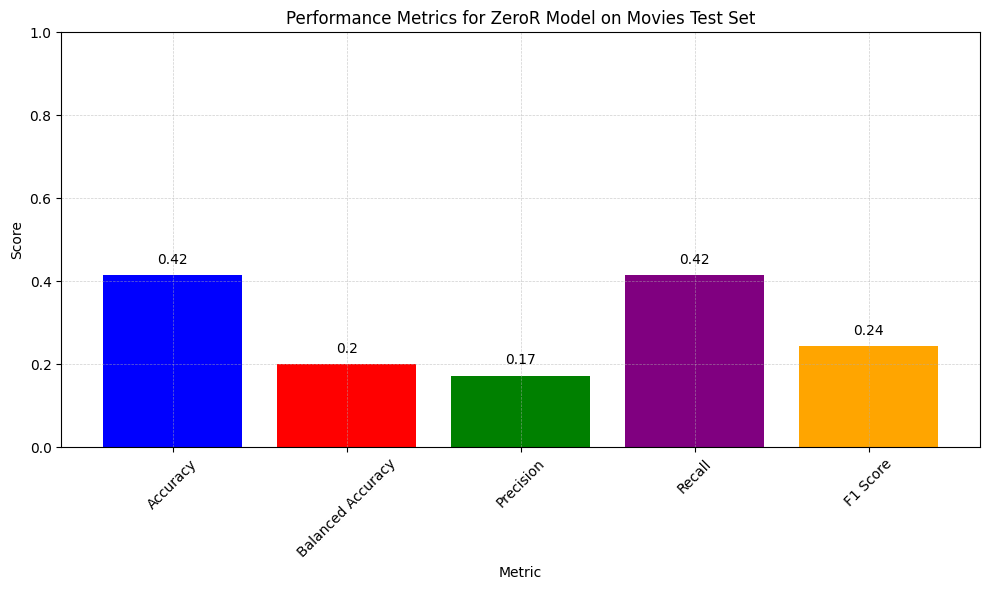

In [56]:
# Initialize the ZeroR model
zero_r = DummyClassifier(strategy="most_frequent")
zero_r.fit(X_train_movies, y_train_movies)

# Make predictions
y_pred_zeror_movies = zero_r.predict(X_test_movies)

# Calculate metrics
accuracy_zeror_movies = accuracy_score(y_test_movies, y_pred_zeror_movies)
balanced_accuracy = balanced_accuracy_score(y_test_movies, y_pred_zeror_movies)
precision = precision_score(y_test_movies, y_pred_zeror_movies, average='weighted', zero_division=0)
recall = recall_score(y_test_movies, y_pred_zeror_movies, average='weighted')
f1 = f1_score(y_test_movies, y_pred_zeror_movies, average='weighted')

# Create a dictionary for metrics
metrics = {
    "Accuracy": accuracy_zeror_movies,
    "Balanced Accuracy": balanced_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

# Function to plot metrics with values on top of the bars and with a grid
def plot_metrics(metrics, title):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(list(metrics.keys()), list(metrics.values()), color=['blue', 'red', 'green', 'purple', 'orange'])
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.title(title)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)

    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("zeror_movies.png")
    plt.show()

# Plot for Movies
plot_metrics(metrics, 'Performance Metrics for ZeroR Model on Movies Test Set')

## TV Shows

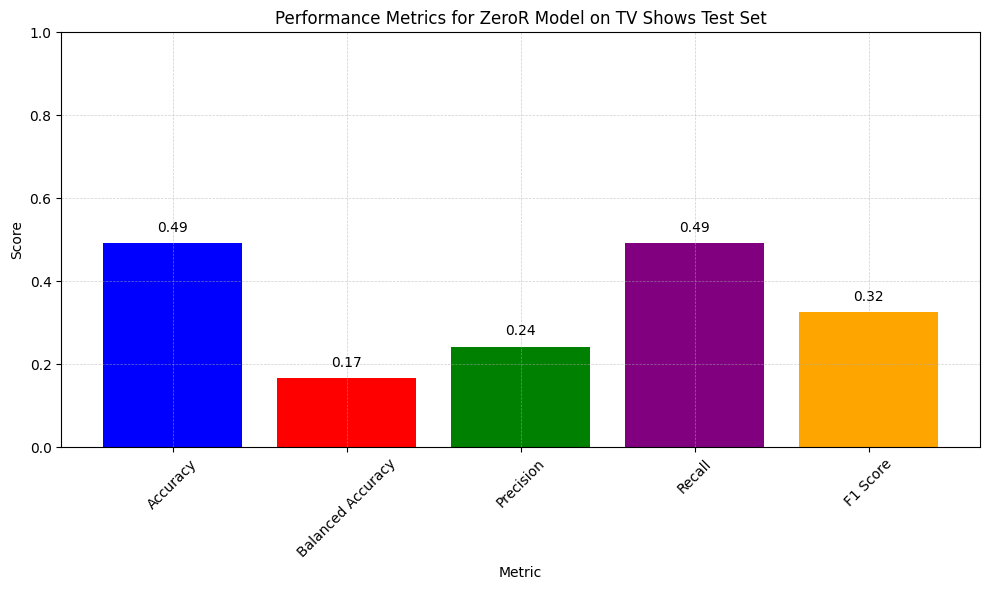

In [57]:
# Initialize the ZeroR model
zero_r = DummyClassifier(strategy="most_frequent")
zero_r.fit(X_train_tvshows, y_train_tvshows)

# Make predictions
y_pred_zeror_tvshows = zero_r.predict(X_test_tvshows)

# Calculate metrics for TV shows
accuracy_zeror_tvshows = accuracy_score(y_test_tvshows, y_pred_zeror_tvshows)
balanced_accuracy_tvshows = balanced_accuracy_score(y_test_tvshows, y_pred_zeror_tvshows)
precision_tvshows = precision_score(y_test_tvshows, y_pred_zeror_tvshows, average='weighted', zero_division=0)
recall_tvshows = recall_score(y_test_tvshows, y_pred_zeror_tvshows, average='weighted')
f1_tvshows = f1_score(y_test_tvshows, y_pred_zeror_tvshows, average='weighted')

# Create a dictionary for TV shows metrics
metrics = {
    "Accuracy": accuracy_zeror_tvshows,
    "Balanced Accuracy": balanced_accuracy_tvshows,
    "Precision": precision_tvshows,
    "Recall": recall_tvshows,
    "F1 Score": f1_tvshows
}

# Function to plot metrics with values on top of the bars and with a grid
def plot_metrics(metrics, title):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(list(metrics.keys()), list(metrics.values()), color=['blue', 'red', 'green', 'purple', 'orange'])
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.title(title)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(linestyle='--', linewidth=0.5, alpha=0.6)

    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("zeror_tvshows.png")
    plt.show()

# Plot for TV Shows
plot_metrics(metrics, 'Performance Metrics for ZeroR Model on TV Shows Test Set')

# Machine Learning

# KNN

## Determining an appropriate number of folds (Movies)

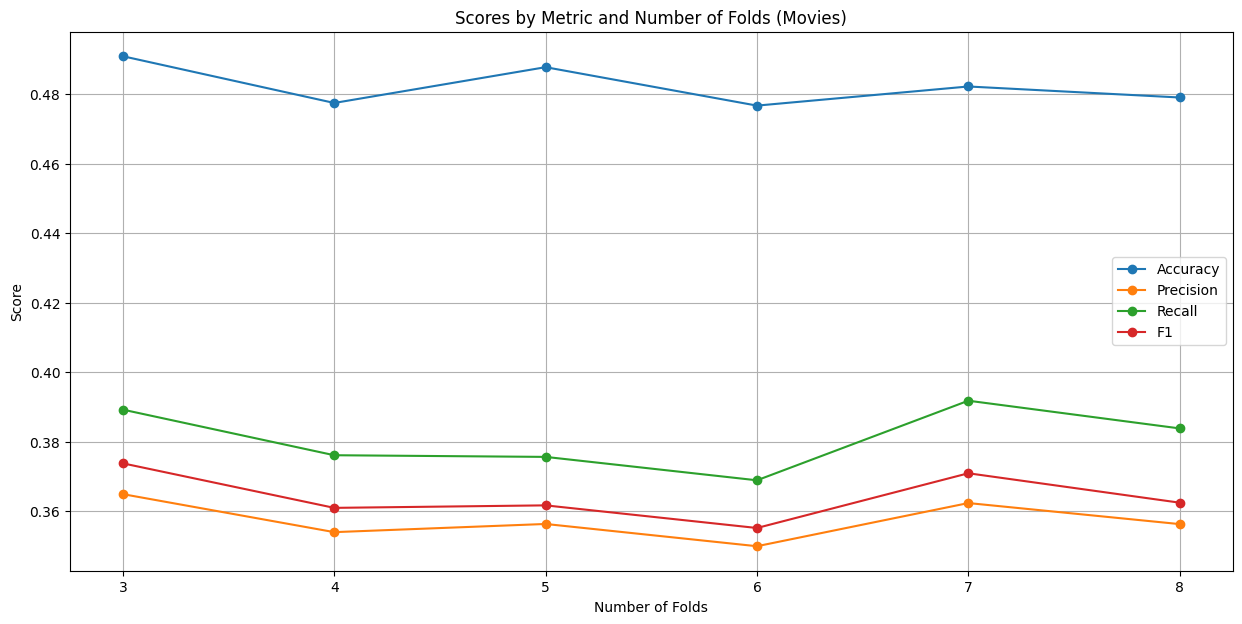

In [58]:
# Calculate metrics for 3-10 fold cross-validation
fold_metrics = {}
folds = [3, 4, 5, 6, 7, 8]

for fold in folds:
    skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=1)

    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for train_idx, test_idx in skf.split(X_movies, y_movies):
      X_train, X_test = X_movies.iloc[train_idx], X_movies.iloc[test_idx]
      y_train, y_test = y_movies.iloc[train_idx], y_movies.iloc[test_idx]

      scaler = StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

      # Use 3 neighbours for now as placeholder
      knn = KNeighborsClassifier(n_neighbors=3)
      knn.fit(X_train, y_train)

      y_pred = knn.predict(X_test)

      fold_accuracies.append(accuracy_score(y_test, y_pred))
      fold_precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
      fold_recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
      fold_f1s.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

    fold_metrics[fold] = [sum(fold_accuracies)/fold, sum(fold_precisions)/fold,
                          sum(fold_recalls)/fold, sum(fold_f1s)/fold]

# Extracting metrics for plotting
folds = list(fold_metrics.keys())
accuracy = [fold_metrics[k][0] for k in folds]
precision = [fold_metrics[k][1] for k in folds]
recall = [fold_metrics[k][2] for k in folds]
f1 = [fold_metrics[k][3] for k in folds]

# Plotting the metrics
plt.figure(figsize=(15, 7))
plt.plot(folds, accuracy, label='Accuracy', marker='o')
plt.plot(folds, precision, label='Precision', marker='o')
plt.plot(folds, recall, label='Recall', marker='o')
plt.plot(folds, f1, label='F1', marker='o')

plt.title('Scores by Metric and Number of Folds (Movies)')
plt.xlabel('Number of Folds')
plt.ylabel('Score')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.savefig('folds_movies.png')
plt.show()


## Determining an appropriate number of folds (TV Shows)

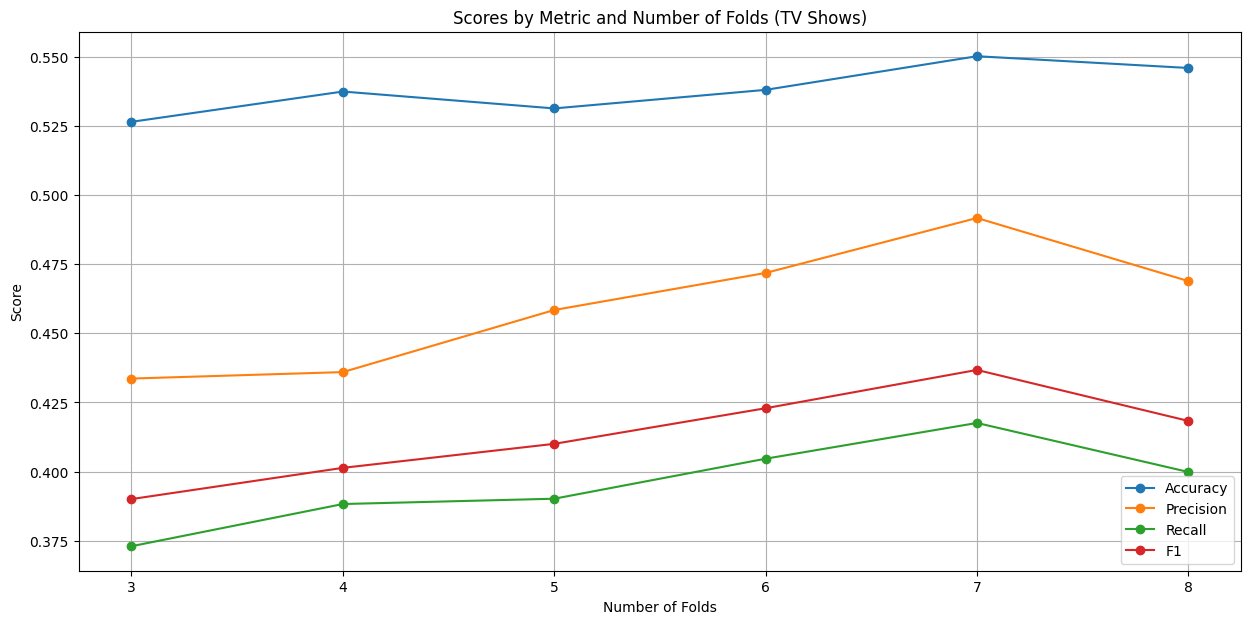

In [59]:
# Calculate metrics for 3, 5, and 10 fold cross-validation
fold_metrics = {}
folds = [3, 4, 5, 6, 7, 8]

for fold in folds:
    skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=1)

    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for train_idx, test_idx in skf.split(X_tvshows, y_tvshows):
      X_train, X_test = X_tvshows.iloc[train_idx], X_tvshows.iloc[test_idx]
      y_train, y_test = y_tvshows.iloc[train_idx], y_tvshows.iloc[test_idx]

      scaler = StandardScaler().fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

      # Use 3 neighbours for now as placeholder
      knn = KNeighborsClassifier(n_neighbors=3)
      knn.fit(X_train, y_train)

      y_pred = knn.predict(X_test)

      fold_accuracies.append(accuracy_score(y_test, y_pred))
      fold_precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
      fold_recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
      fold_f1s.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

    fold_metrics[fold] = [sum(fold_accuracies)/fold, sum(fold_precisions)/fold,
                          sum(fold_recalls)/fold, sum(fold_f1s)/fold]

# Extracting metrics for plotting
folds = list(fold_metrics.keys())
accuracy = [fold_metrics[k][0] for k in folds]
precision = [fold_metrics[k][1] for k in folds]
recall = [fold_metrics[k][2] for k in folds]
f1 = [fold_metrics[k][3] for k in folds]

# Plotting the metrics
plt.figure(figsize=(15, 7))
plt.plot(folds, accuracy, label='Accuracy', marker='o')
plt.plot(folds, precision, label='Precision', marker='o')
plt.plot(folds, recall, label='Recall', marker='o')
plt.plot(folds, f1, label='F1', marker='o')

plt.title('Scores by Metric and Number of Folds (TV Shows)')
plt.xlabel('Number of Folds')
plt.ylabel('Score')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.savefig('folds_tvshows.png')
plt.show()


## Determining an appropriate number of neighbours (Movies)

{1: [0.4758484609313339, 0.3484854424459322, 0.34286736980034177, 0.34184111265634], 2: [0.4267780408664387, 0.3402938711432478, 0.361735046168547, 0.3295724839991924], 3: [0.4821888976585109, 0.3623609143904109, 0.3918018061863911, 0.37093174135589363], 4: [0.5019950890116636, 0.3858926440315453, 0.3872948637848162, 0.38345619010665183], 5: [0.5043585021485574, 0.40940887388891545, 0.3934834502827628, 0.3962802221939884], 6: [0.49800052617732177, 0.40326001594536853, 0.3852498212265531, 0.38997801724708087]}


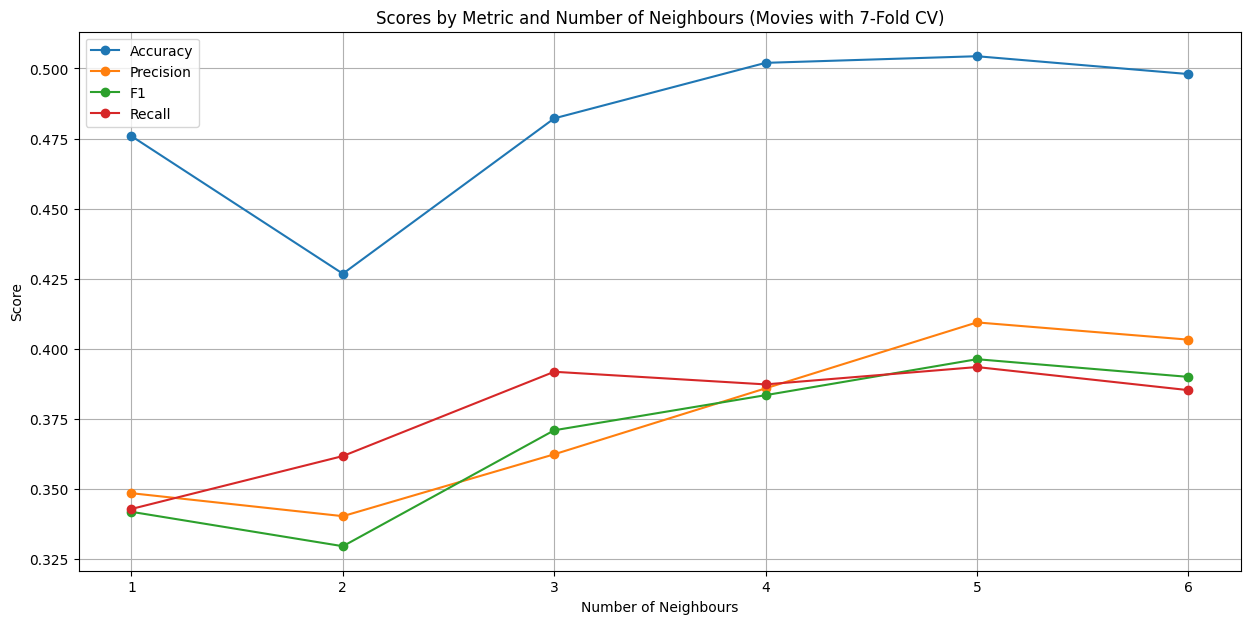

In [60]:
# List to store cross-validated metrics
n_metrics = {}

# Reinitialize the range of neighbors to consider
n_range = range(1, 7)
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
for n_neighbors in n_range:
    n_accuracies = []
    n_precisions = []
    n_recalls = []
    n_f1s = []

    for train_idx, test_idx in skf.split(X_movies, y_movies):
        X_train, X_test = X_movies.iloc[train_idx], X_movies.iloc[test_idx]
        y_train, y_test = y_movies.iloc[train_idx], y_movies.iloc[test_idx]

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        n_accuracies.append(accuracy_score(y_test, y_pred))
        n_precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        n_recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
        n_f1s.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

    n_metrics[n_neighbors] = [sum(n_accuracies)/len(n_accuracies), sum(n_precisions)/len(n_precisions),
                              sum(n_recalls)/len(n_recalls), sum(n_f1s)/len(n_f1s)]

# Extract metrics for plotting
accuracy = [n_metrics[n][0] for n in n_range]
precision = [n_metrics[n][1] for n in n_range]
recall = [n_metrics[n][2] for n in n_range]
f1 = [n_metrics[n][3] for n in n_range]

print(n_metrics)

# Plotting the metrics
plt.figure(figsize=(15, 7))
plt.plot(n_range, accuracy, label='Accuracy', marker='o')
plt.plot(n_range, precision, label='Precision', marker='o')
plt.plot(n_range, f1, label='F1', marker='o')
plt.plot(n_range, recall, label='Recall', marker='o')

plt.title('Scores by Metric and Number of Neighbours (Movies with 7-Fold CV)')
plt.xlabel('Number of Neighbours')
plt.ylabel('Score')
plt.xticks(n_range)
plt.legend()
plt.grid(True)
plt.savefig('neighbours_movies.png')
plt.show()

## Determining an appropriate number of neighbours (TV Shows)

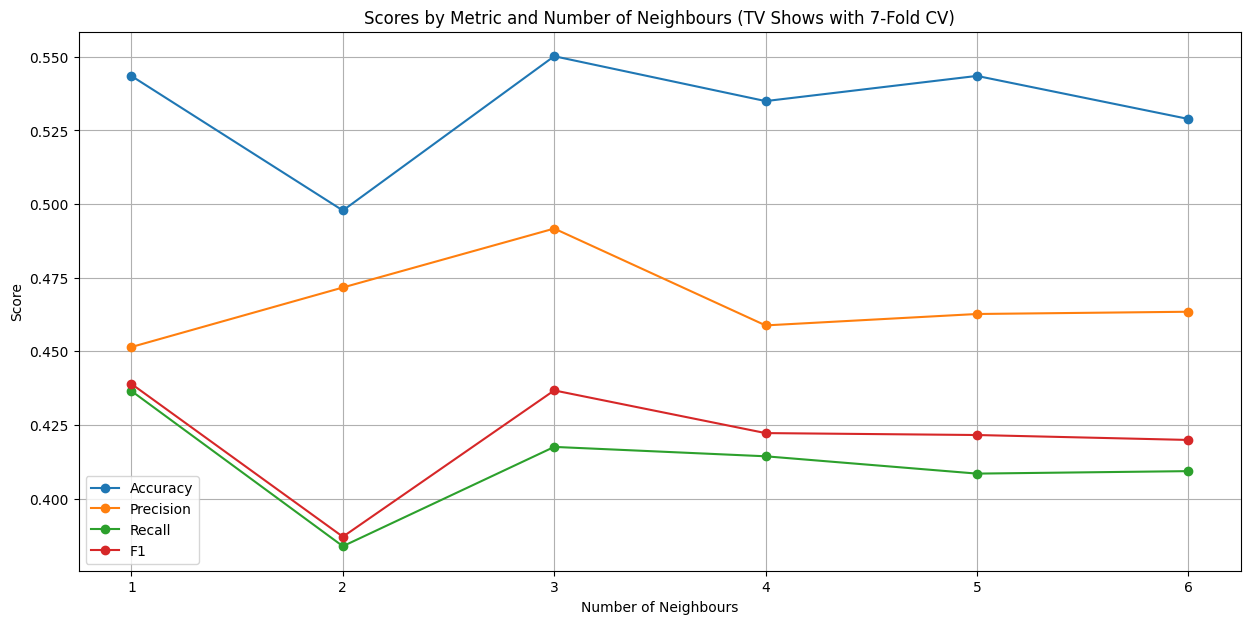

In [61]:
# List to store cross-validated metrics
n_metrics = {}

# Reinitialize the range of neighbors to consider
n_range = range(1, 7)
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=1)
for n_neighbors in n_range:
    n_accuracies = []
    n_precisions = []
    n_recalls = []
    n_f1s = []

    for train_idx, test_idx in skf.split(X_tvshows, y_tvshows):
        X_train, X_test = X_tvshows.iloc[train_idx], X_tvshows.iloc[test_idx]
        y_train, y_test = y_tvshows.iloc[train_idx], y_tvshows.iloc[test_idx]

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        n_accuracies.append(accuracy_score(y_test, y_pred))
        n_precisions.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        n_recalls.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
        n_f1s.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

    n_metrics[n_neighbors] = [sum(n_accuracies)/len(n_accuracies), sum(n_precisions)/len(n_precisions),
                              sum(n_recalls)/len(n_recalls), sum(n_f1s)/len(n_f1s)]

# Extract metrics for plotting
accuracy = [n_metrics[n][0] for n in n_range]
precision = [n_metrics[n][1] for n in n_range]
recall = [n_metrics[n][2] for n in n_range]
f1 = [n_metrics[n][3] for n in n_range]

# Plotting the metrics
plt.figure(figsize=(15, 7))
plt.plot(n_range, accuracy, label='Accuracy', marker='o')
plt.plot(n_range, precision, label='Precision', marker='o')
plt.plot(n_range, recall, label='Recall', marker='o')
plt.plot(n_range, f1, label='F1', marker='o')

plt.title('Scores by Metric and Number of Neighbours (TV Shows with 7-Fold CV)')
plt.xlabel('Number of Neighbours')
plt.ylabel('Score')
plt.xticks(n_range)
plt.legend()
plt.grid(True)
plt.savefig('neighbours_tvshows.png')
plt.show()

# KNN with 5-NN classifier (Movies)

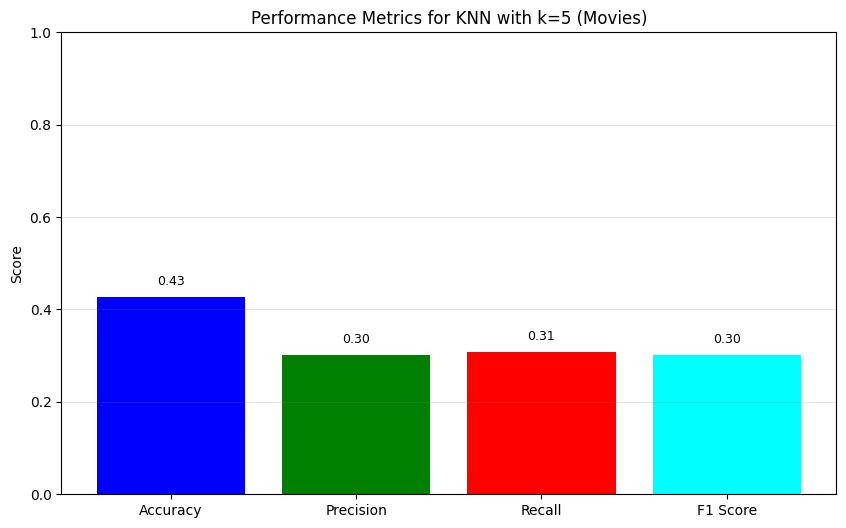

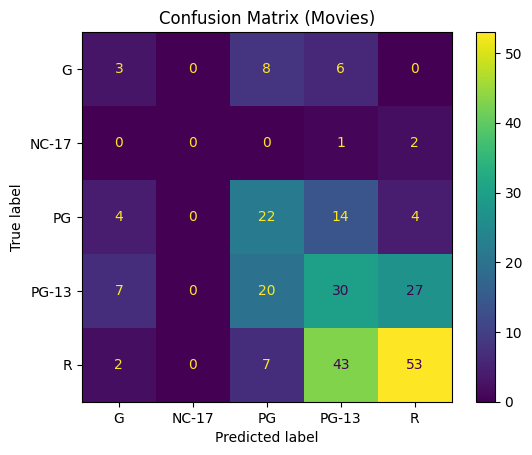

In [62]:
scaler = StandardScaler().fit(X_train_movies)
X_train = scaler.transform(X_train_movies)
X_test = scaler.transform(X_test_movies)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_movies)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test_movies, y_pred)
precision = precision_score(y_test_movies, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test_movies, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test_movies, y_pred, average='macro', zero_division=0)

metrics_values = [accuracy, precision, recall, f1]
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Visualization of metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics_labels, metrics_values, color=['blue', 'green', 'red', 'cyan'])
plt.ylabel('Score')
plt.title('Performance Metrics for KNN with k=5 (Movies)')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.2, c="gray")

for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.savefig('knn_movies.png')
plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_test_movies, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['G', 'NC-17', "PG", "PG-13", "R"])

disp.plot()
plt.title("Confusion Matrix (Movies)")
print("\n")
plt.savefig('cm_movies.png')
plt.show()

# KNN with 3-NN classifier (TV Shows)

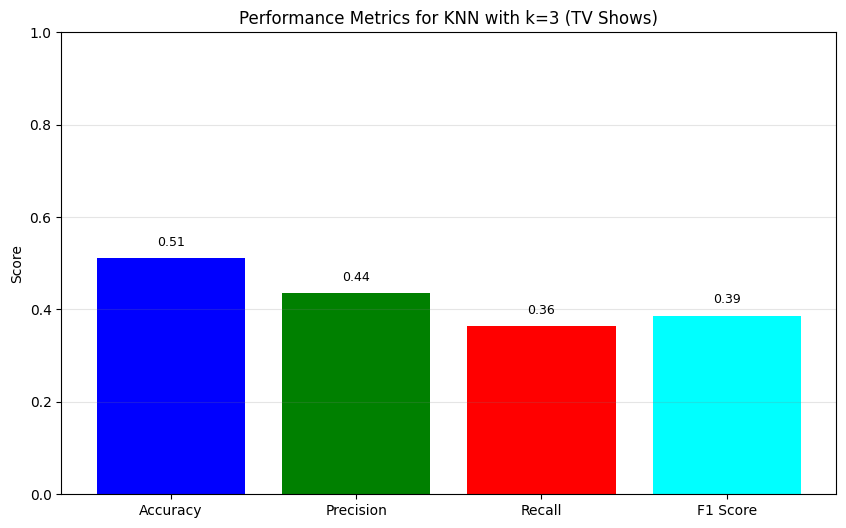

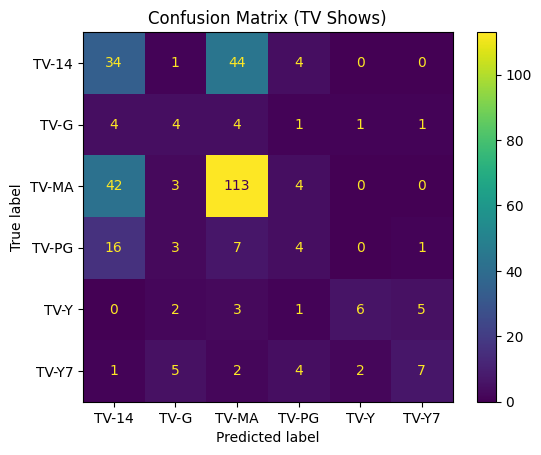

In [63]:
scaler = StandardScaler().fit(X_train_tvshows)
X_train = scaler.transform(X_train_tvshows)
X_test = scaler.transform(X_test_tvshows)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train_tvshows)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test_tvshows, y_pred)
precision = precision_score(y_test_tvshows, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test_tvshows, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test_tvshows, y_pred, average='macro', zero_division=0)

metrics_values = [accuracy, precision, recall, f1]
metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Visualization of metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics_labels, metrics_values, color=['blue', 'green', 'red', 'cyan'])
plt.ylabel('Score')
plt.title('Performance Metrics for KNN with k=3 (TV Shows)')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.2, c="gray")

for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.savefig('knn_tvshows.png')
plt.show()

# Generate the confusion matrix
cm = confusion_matrix(y_test_tvshows, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['TV-14', 'TV-G', "TV-MA", "TV-PG", "TV-Y", "TV-Y7"])

disp.plot()
plt.title("Confusion Matrix (TV Shows)")
print("\n")
plt.savefig('cm_tvshows.png')
plt.show()

## Decision Tree

In [64]:
X = X_movies
X_tvshow = tv_shows.drop(columns=['age_certification', 'age_certification_encoded', 'genres',
                         'production_countries', "release_year", "runtime", "imdb_score",
                         "imdb_votes", "tmdb_popularity", "tmdb_score", "title", "description", "Description Words",
                         "Title Words", "binned_runtime", "binned_release_year"])
y = movies['age_certification_encoded']
y_tvshow = tv_shows['age_certification_encoded']
X.columns



Index(['action', 'animation', 'comedy', 'crime', 'documentation', 'drama',
       'european', 'family', 'fantasy', 'history', 'horror', 'music',
       'reality', 'romance', 'scifi', 'sport', 'thriller', 'war', 'western',
       'AE', 'AL', 'AR', 'AT', 'AU', 'BE', 'BG', 'BR', 'CA', 'CH', 'CL', 'CN',
       'CO', 'CY', 'CZ', 'DE', 'DK', 'EG', 'ES', 'FR', 'GB', 'GH', 'GR', 'HK',
       'HU', 'ID', 'IE', 'IL', 'IN', 'IR', 'IS', 'IT', 'JO', 'JP', 'KH', 'KR',
       'LB', 'LT', 'LU', 'MC', 'MT', 'MU', 'MX', 'NG', 'NL', 'NO', 'NZ', 'PE',
       'PH', 'PK', 'PL', 'PR', 'PT', 'QA', 'RO', 'RS', 'RU', 'SE', 'SG', 'SN',
       'TH', 'TR', 'TW', 'UA', 'US', 'VA', 'XX', 'ZA', 'ZW',
       'binned_imdb_votes', 'binned_tmdb_popularity'],
      dtype='object')

In [65]:

from sklearn.tree import DecisionTreeClassifier, plot_tree
evaluation_score_labels = ['accuracy', 'balanced_accuracy', 'f1_score', 'recall_score', 'precision_score']
# get evaluation scores for one method
def get_evaluation_scores(y_test, y_pred):
  evaluation_result = {}

  evaluation_result['accuracy'] = accuracy_score(y_test, y_pred)
  evaluation_result['balanced_accuracy'] = balanced_accuracy_score(y_test, y_pred)
  evaluation_result['f1_score'] = f1_score(y_test, y_pred, average='weighted')
  evaluation_result['recall_score'] = recall_score(y_test, y_pred, average='weighted')
  evaluation_result['precision_score'] = precision_score(y_test, y_pred, average='weighted')

  return evaluation_result

def plot_evaluation_scores(score_data, out=None, title="", xlabel=""):
  #example score data:
  for key, value in score_data.items():
      plt.plot(value, label=key)
  plt.legend()
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel("score")
  plt.show()


max_depth = 30
score_data = {
    "accuracy": [],
    "balanced_accuracy": [],
    "f1_score": [],
    "recall_score": [],
    "precision_score": [],
}
score_data_kfold = {
    "accuracy": [],
    "balanced_accuracy": [],
    "f1_score": [],
    "recall_score": [],
    "precision_score": [],
}
depth_dt = {}
depth_y_pred = {}
depth_scores = {}




In [66]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_evaluation_tree(title,dt):
    plt.figure(figsize=(22, 15))
    plot_tree(dt, feature_names=list(X.columns))
    plt.title("Decision Tree with class weights, max depth="+str(max_depth))
    plt.savefig("./test_decision_tree.png", bbox_inches="tight")
    plt.show()

    # Define the labels
    labels = y.unique()

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])
    # Create the display object and plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['G', 'NC-17', "PG", "PG-13", "R"])
    disp.plot()
    plt.title(f"Confusion matrix for Decision Tree with max_depth={max_depth}")
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

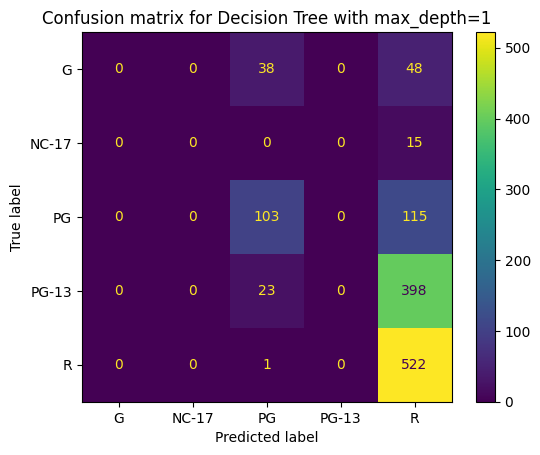

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

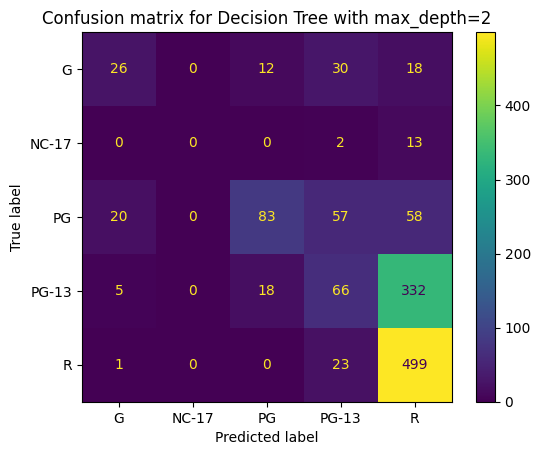

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

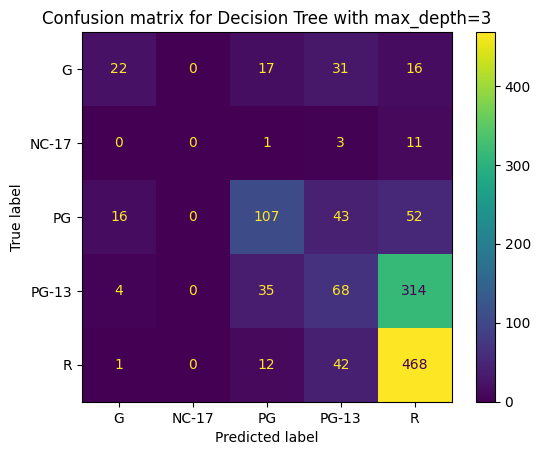

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

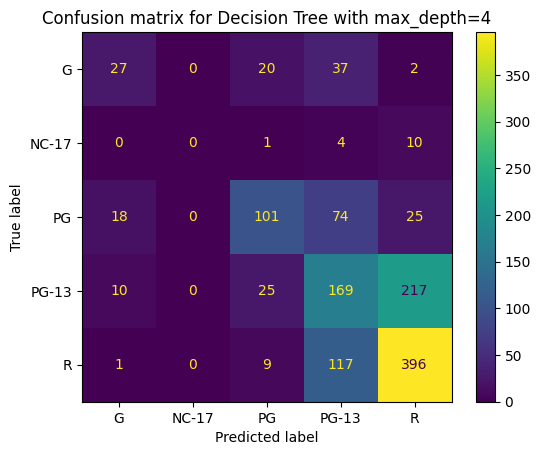

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

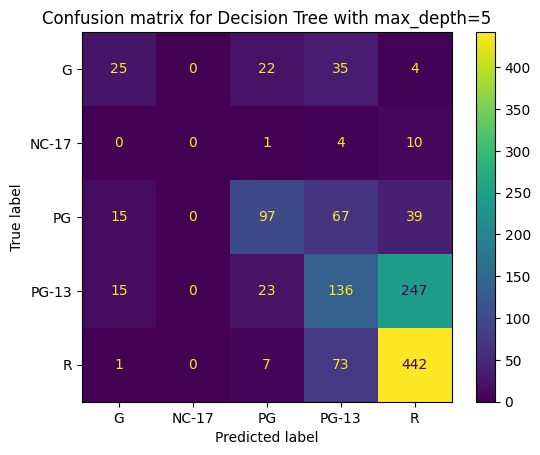

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

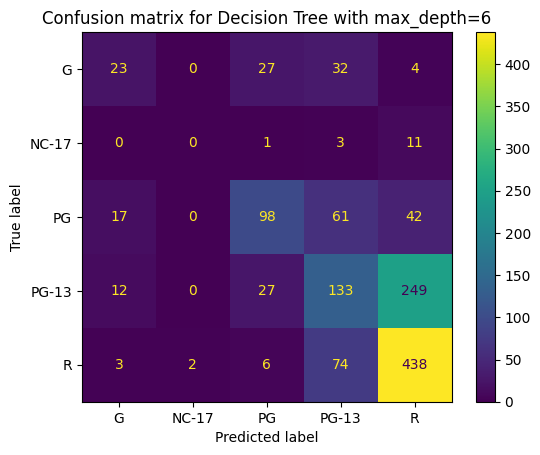

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

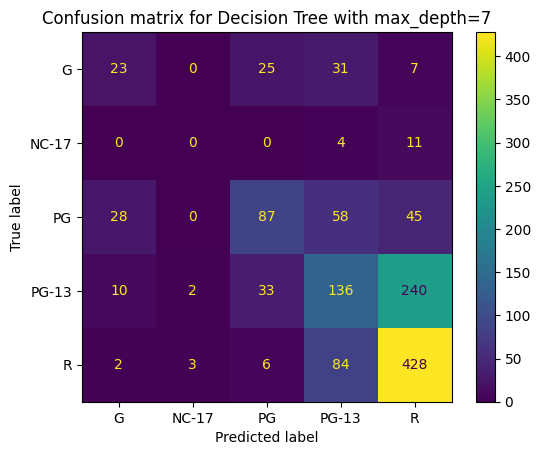

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

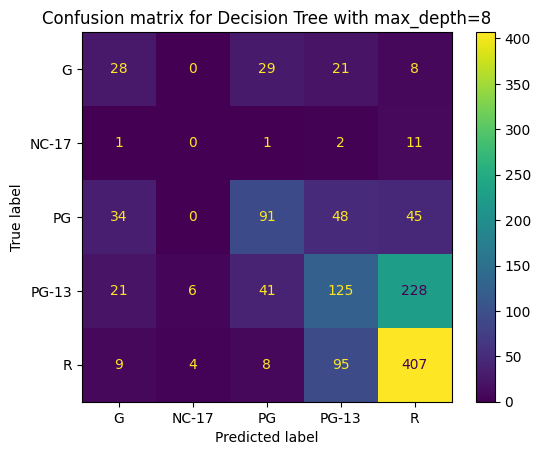

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

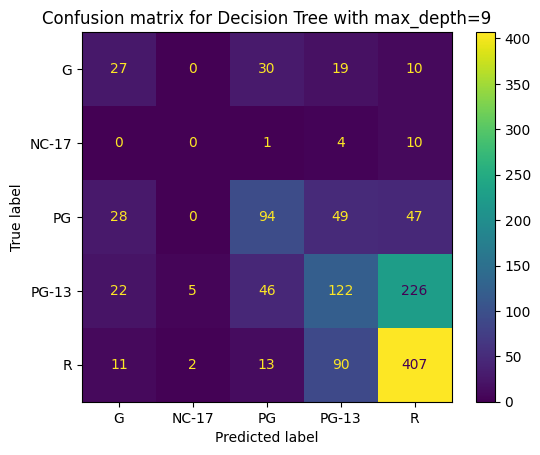

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

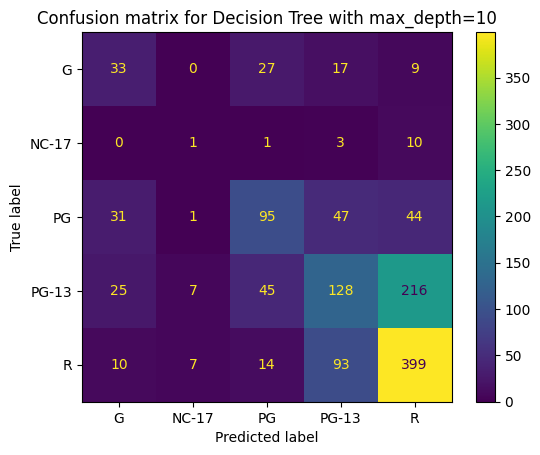

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/

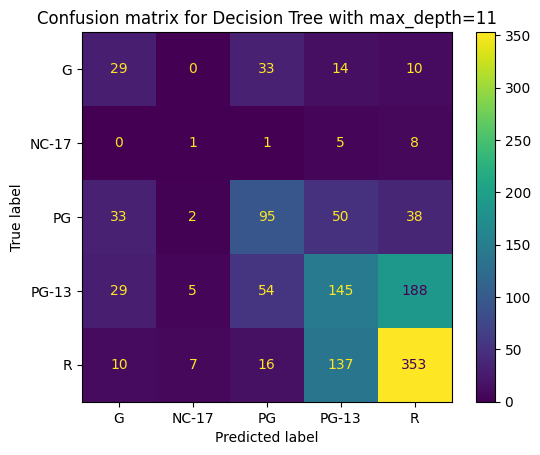

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/

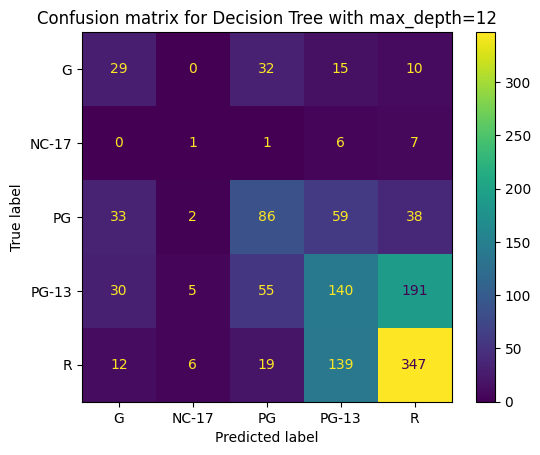

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

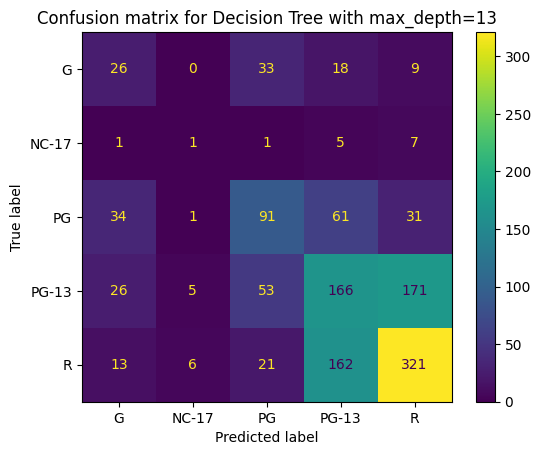

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-p

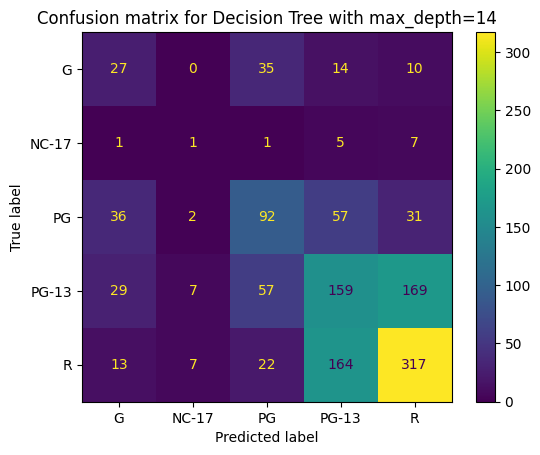

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-p

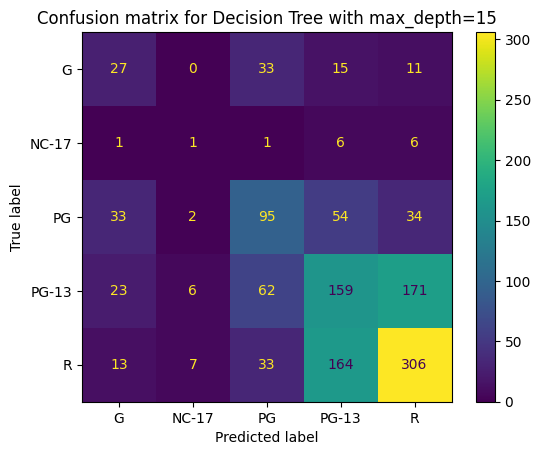

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/

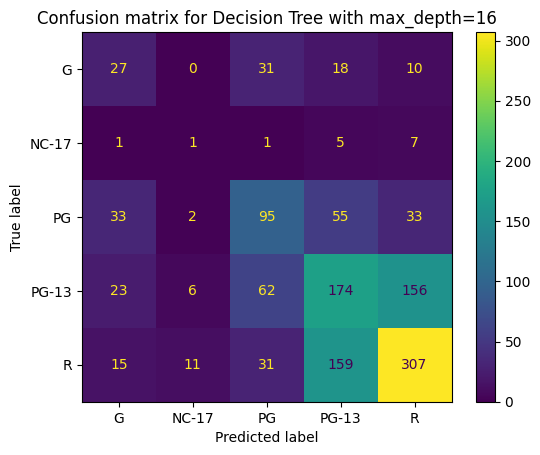

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-p

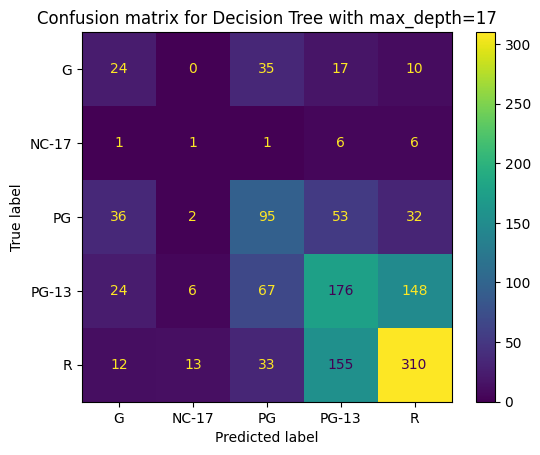

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-p

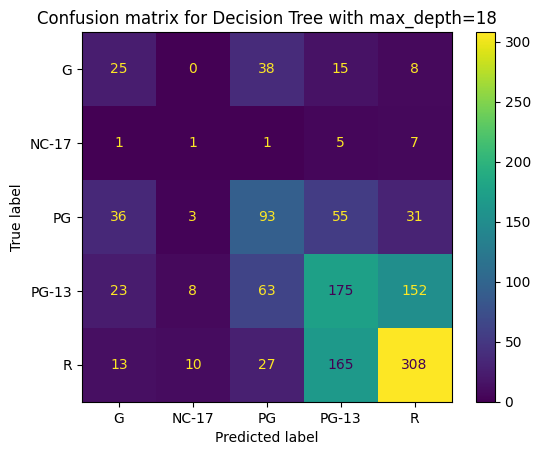

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-p

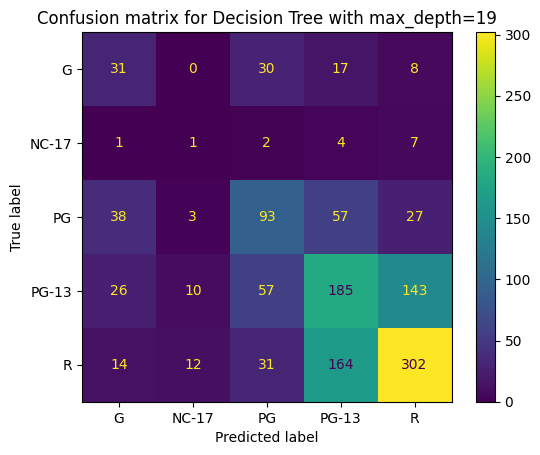

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


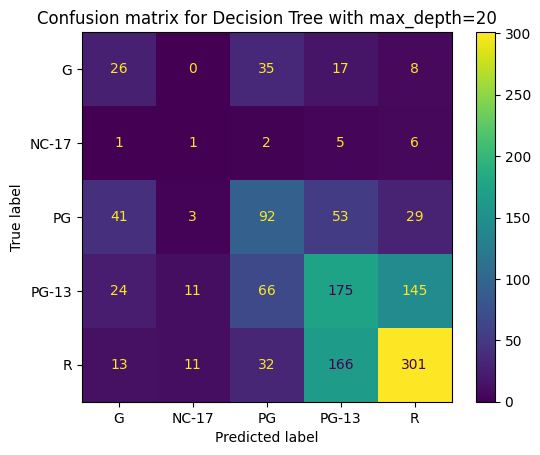

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-p

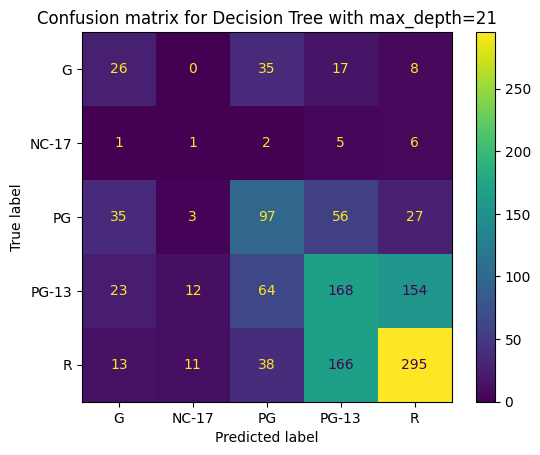

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


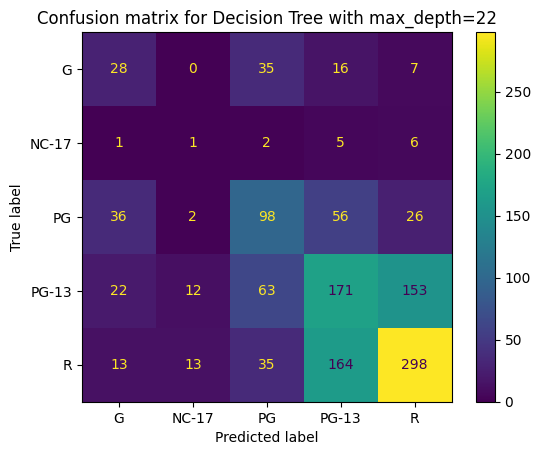

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


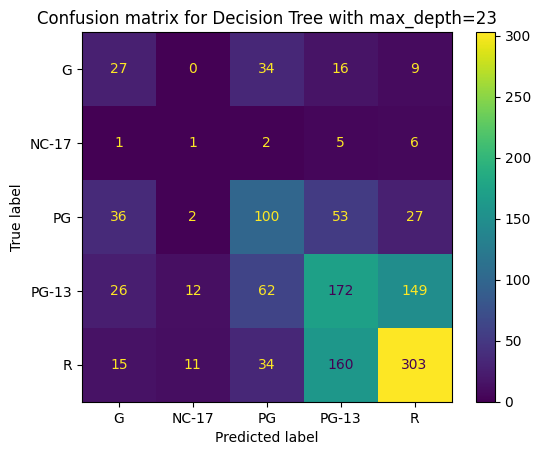

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


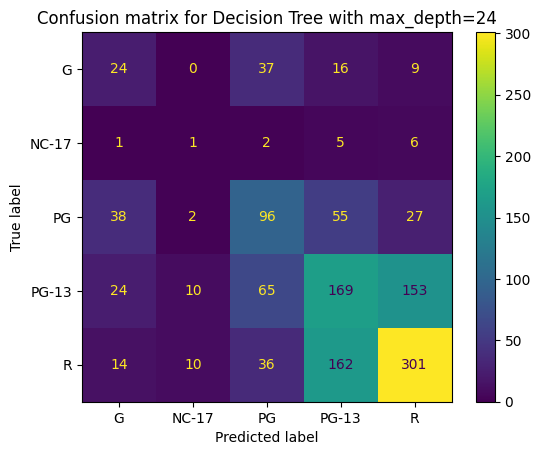

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


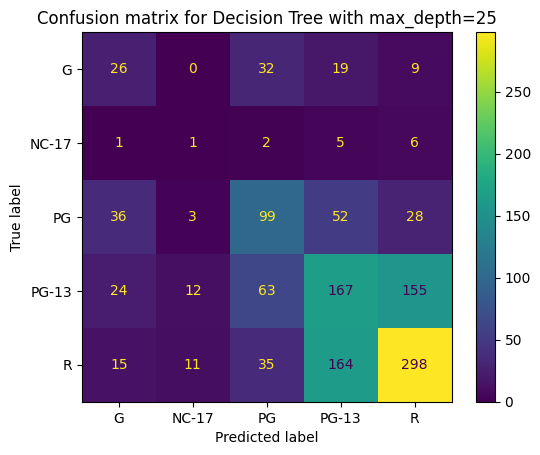

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


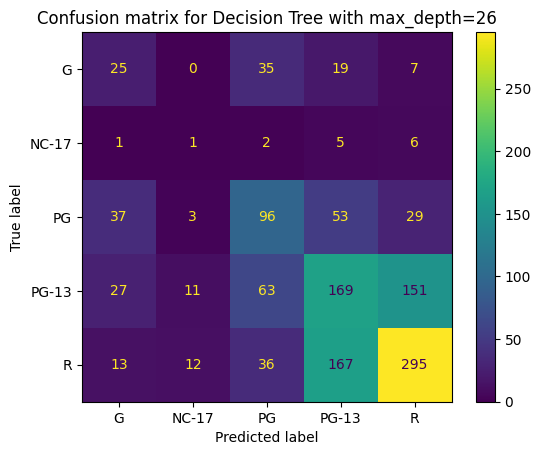

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


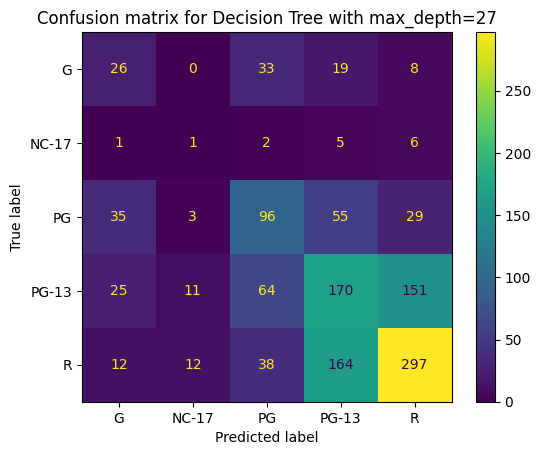

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


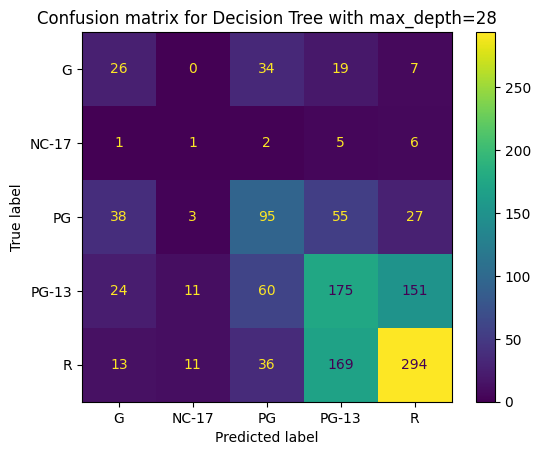

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


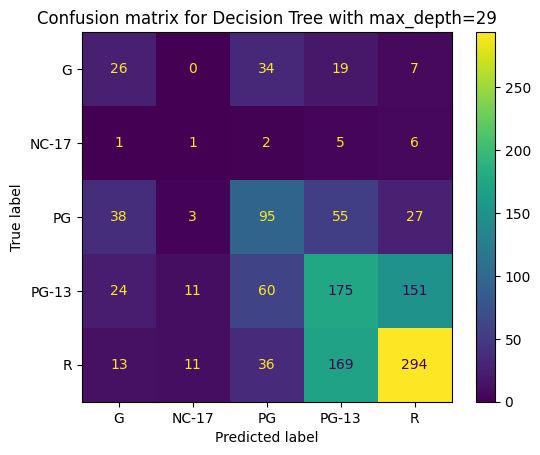

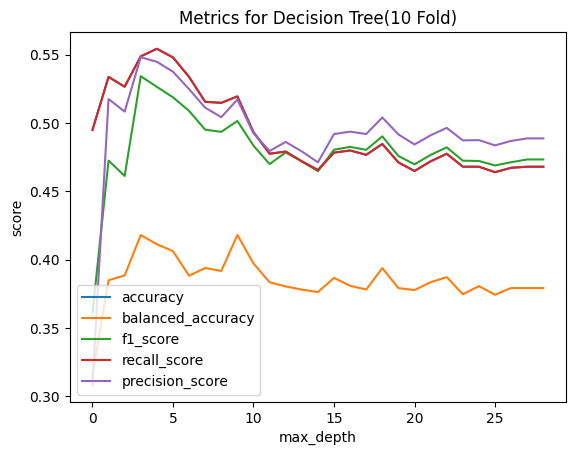

{'accuracy': [0.49483814523184605, 0.5336770403699538, 0.5265154355705537, 0.5487501562304711, 0.5542744656917884, 0.5479502562179727, 0.5337207849018872, 0.5154480689913761, 0.514710661167354, 0.5194038245219347, 0.4932445944256968, 0.4774715660542432, 0.47904011998500184, 0.47187226596675413, 0.4655480564929384, 0.4782527184101987, 0.47984001999750026, 0.47665291838520185, 0.48458942632170976, 0.47109111361079864, 0.4647856517935258, 0.4718972628421447, 0.47742782152230967, 0.467960254968129, 0.46794150731158607, 0.4639607549056368, 0.4671603549556306, 0.4679477565304337, 0.4679477565304337], 'balanced_accuracy': [0.3156492049103437, 0.38480146932101494, 0.38839361551651047, 0.41790608972349713, 0.4112207735443195, 0.40614001971113217, 0.38814174148995234, 0.3938364282445753, 0.39160273538024754, 0.4180039638379567, 0.39709191852709014, 0.3833619493335475, 0.38032254167059243, 0.37800147768653564, 0.37617081746015263, 0.3865877673309059, 0.38076250465461037, 0.3780464971859073, 0.393

In [67]:
from sklearn.model_selection import KFold

# Define the number of folds
k = 10

# Create a KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Define a function to train and evaluate the decision tree using K-fold cross-validation
def train_and_evaluate_movies(X, y, depth):
    scores = {label: [] for label in evaluation_score_labels}
    aggregate_cm = np.zeros((5, 5), dtype=int)
    # Loop over the folds
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the decision tree
        dt = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=depth)
        dt.fit(X_train, y_train)

        # Evaluate the decision tree
        y_pred = dt.predict(X_test)
        evaluation_result = get_evaluation_scores(y_test, y_pred)
        # if depth == 3:
        #   plot_evaluation(dt,X,y_test,y_pred,depth)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])
        aggregate_cm += cm

        # Add the evaluation scores to the scores dictionary
        for label in evaluation_score_labels:
            scores[label].append(evaluation_result[label])


    # Calculate the mean evaluation scores over all folds
    mean_scores = {label: np.mean(scores[label]) for label in evaluation_score_labels}
    disp = ConfusionMatrixDisplay(confusion_matrix=aggregate_cm,display_labels=['G', 'NC-17', "PG", "PG-13", "R"])
    disp.plot()
    plt.title(f"Confusion matrix for Decision Tree with max_depth={depth}")
    plt.show()

    return mean_scores

movies_score_data_kfold = {
    "accuracy": [],
    "balanced_accuracy": [],
    "f1_score": [],
    "recall_score": [],
    "precision_score": [],
}
movies_depth_scores_kfold = {}
for depth in range(1, max_depth):
  DT_result = train_and_evaluate_movies(X, y, depth)
  movies_score_data_kfold['accuracy'].append(DT_result['accuracy'])
  movies_score_data_kfold['balanced_accuracy'].append(DT_result['balanced_accuracy'])
  movies_score_data_kfold['f1_score'].append(DT_result['f1_score'])
  movies_score_data_kfold['recall_score'].append(DT_result['recall_score'])
  movies_score_data_kfold['precision_score'].append(DT_result['precision_score'])
  movies_depth_scores_kfold[depth] = DT_result
plot_evaluation_scores(movies_score_data_kfold, title="Metrics for Decision Tree(10 Fold)", xlabel="max_depth")
score_table_movies = pd.DataFrame(movies_score_data_kfold, index=range(1, max_depth))
print(movies_score_data_kfold)

In [68]:
score_table_movies

accuracy  balanced_accuracy  f1_score  recall_score  precision_score
1   0.494838           0.315649  0.360796      0.494838         0.308325
2   0.533677           0.384801  0.472433      0.533677         0.517491
3   0.526515           0.388394  0.461181      0.526515         0.508302
4   0.548750           0.417906  0.534178      0.548750         0.548129
5   0.554274           0.411221  0.526403      0.554274         0.544727
6   0.547950           0.406140  0.518756      0.547950         0.537497
7   0.533721           0.388142  0.508808      0.533721         0.524742
8   0.515448           0.393836  0.495041      0.515448         0.511169
9   0.514711           0.391603  0.493458      0.514711         0.504207
10  0.519404           0.418004  0.501442      0.519404         0.517114
11  0.493245           0.397092  0.483362      0.493245         0.492410
12  0.477472           0.383362  0.469882      0.477472         0.479481
13  0.479040           0.380323  0.478388      0.479040         0.486092
14  0.471872           0.378001  0.471911      0.471872         0.479141
15  0.465548           0.376171  0.464637      0.465548         0.471172
16  0.478253           0.386588  0.480422      0.478253         0.491863
17  0.479840           0.380763  0.482459      0.479840         0.493611
18  0.476653           0.378046  0.480314      0.476653         0.491884
19  0.484589           0.393731  0.490158      0.484589         0.503972
20  0.471091           0.379077  0.475774      0.471091         0.491586
21  0.464786           0.377663  0.469685      0.464786         0.484236
22  0.471897           0.383380  0.476633      0.471897         0.490924
23  0.477428           0.387157  0.482113      0.477428         0.496383
24  0.467960           0.374575  0.472351      0.467960         0.487227
25  0.467942           0.380528  0.472135      0.467942         0.487418
26  0.463961           0.374245  0.468878      0.463961         0.483558
27  0.467160           0.379163  0.471234      0.467160         0.486847
28  0.467948           0.379122  0.473261      0.467948         0.488670
29  0.467948           0.379122  0.473261      0.467948         0.488670

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

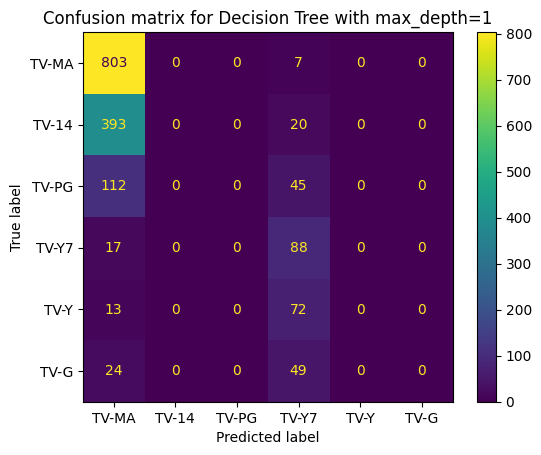

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

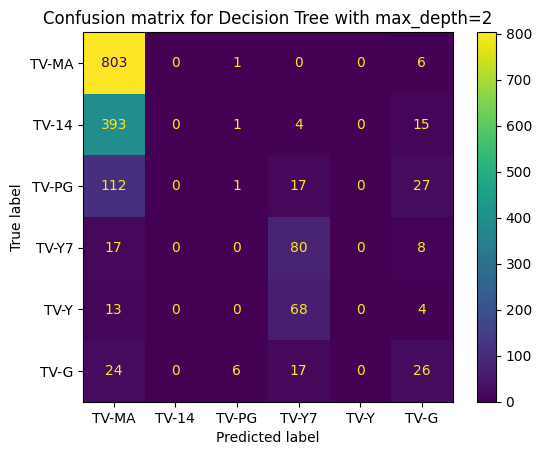

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning

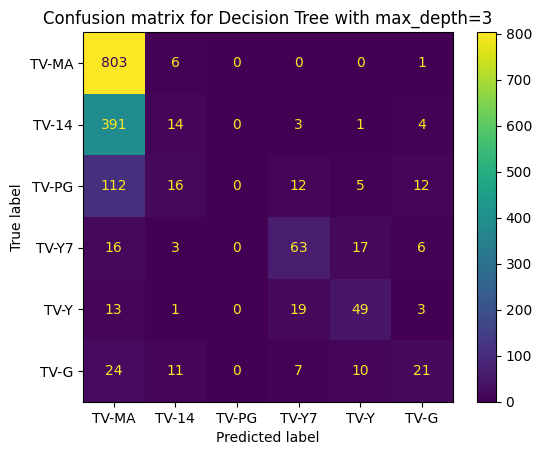

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


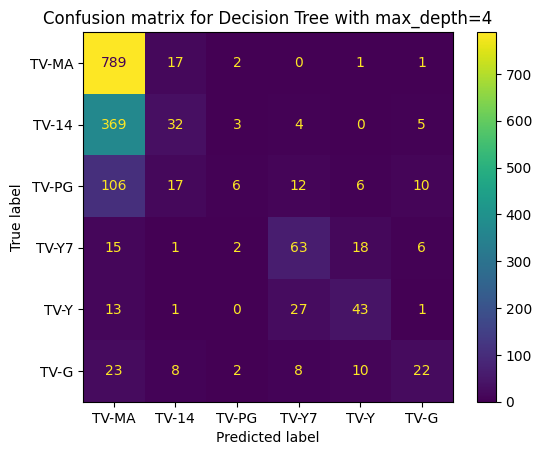

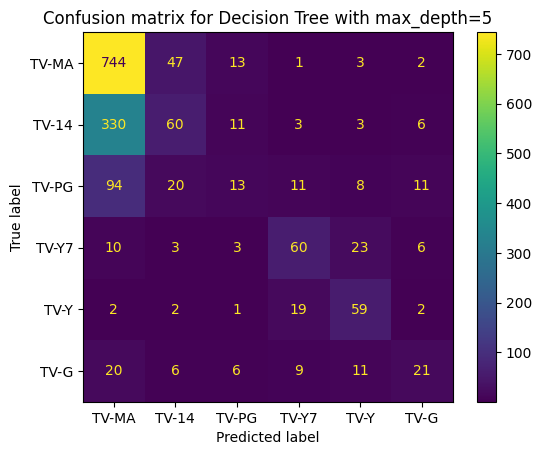

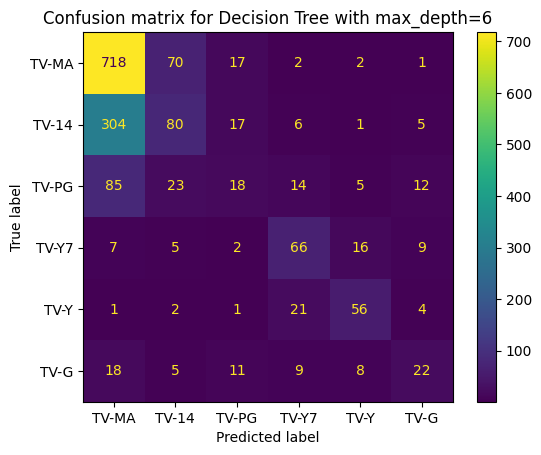

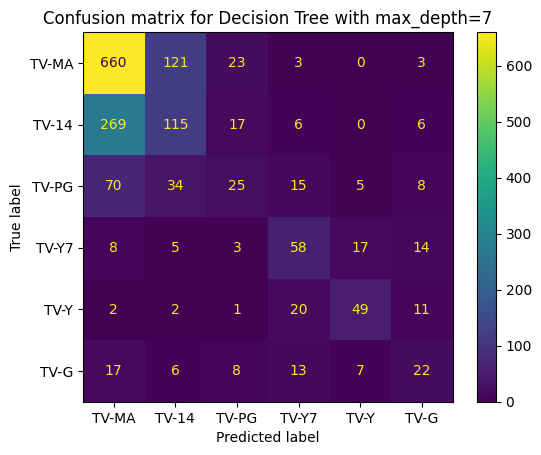

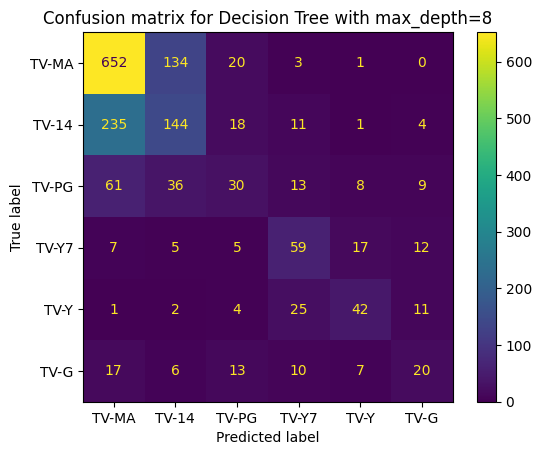

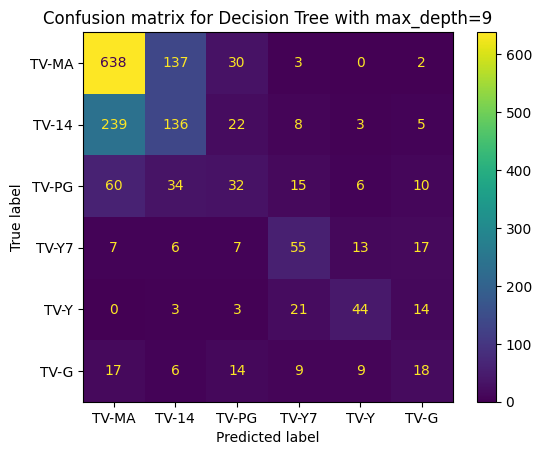

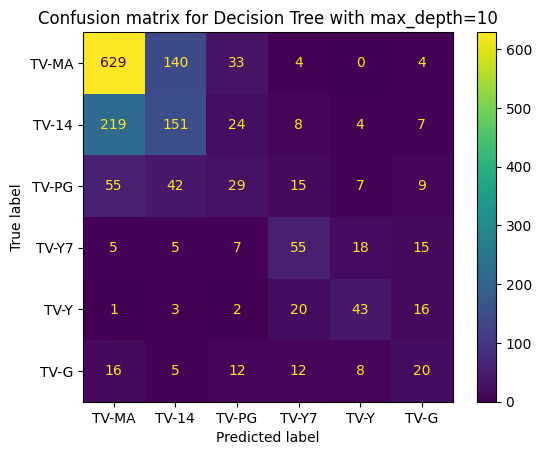

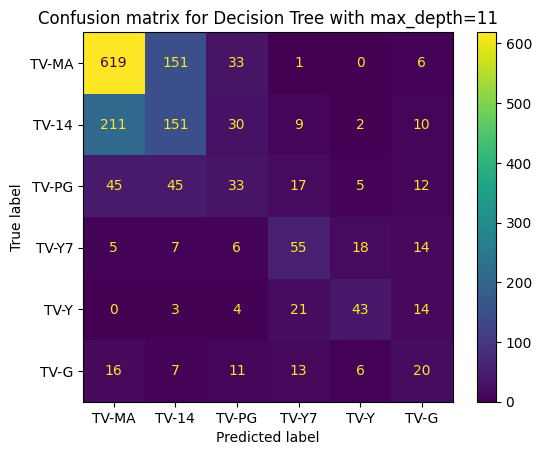

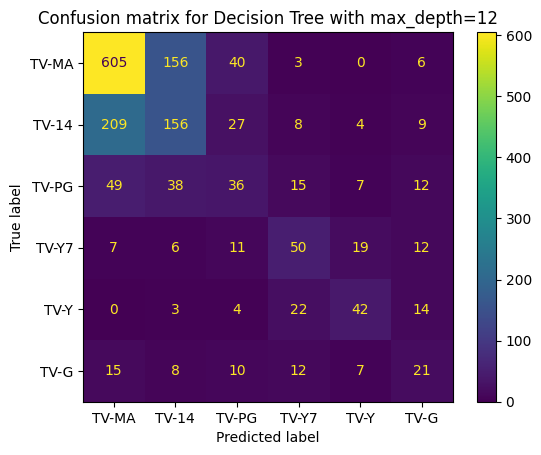

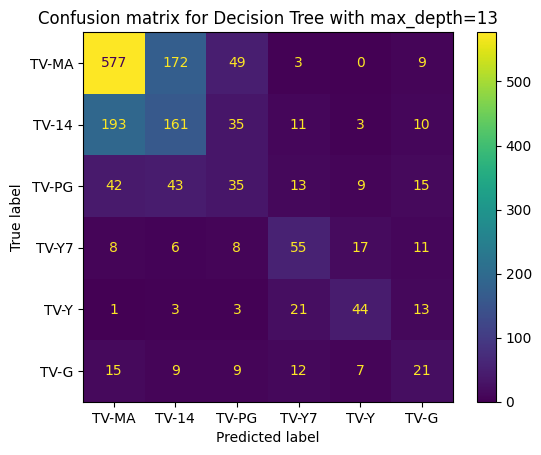

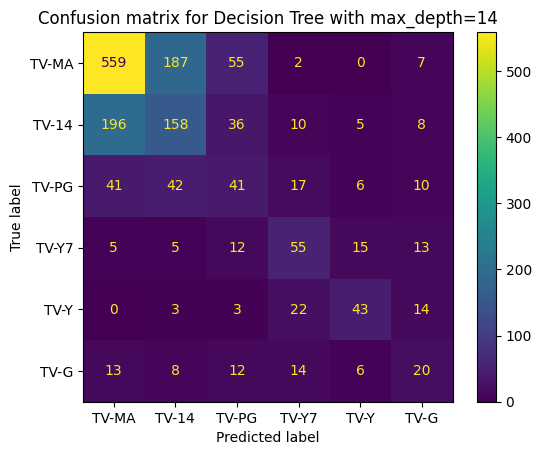

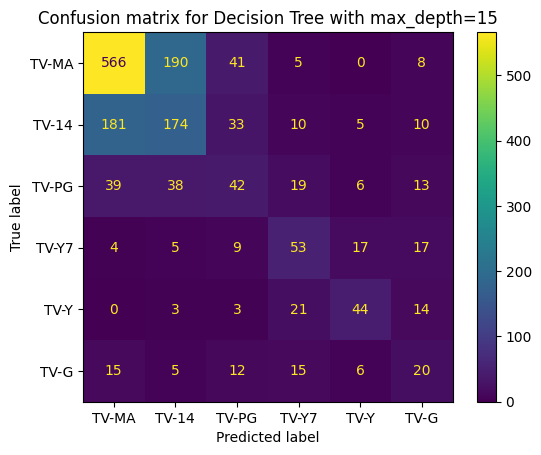

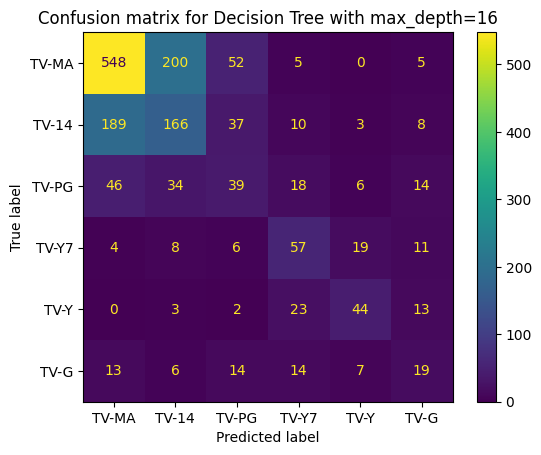

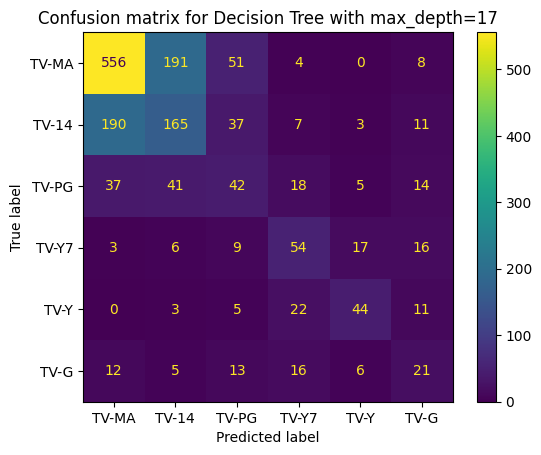

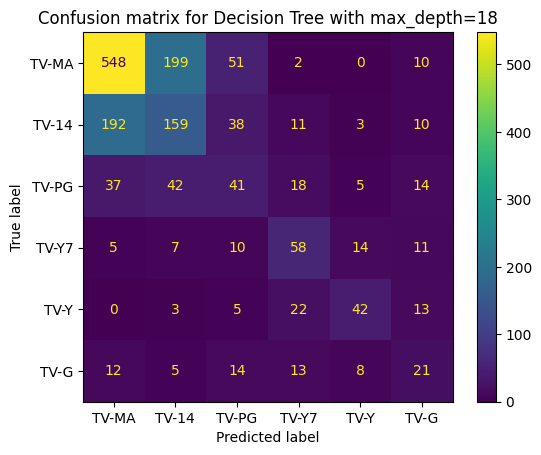

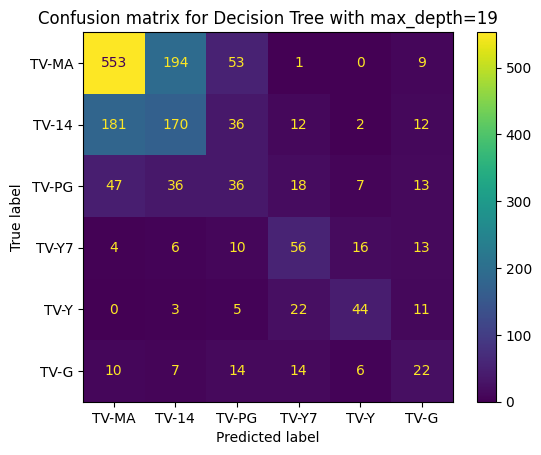

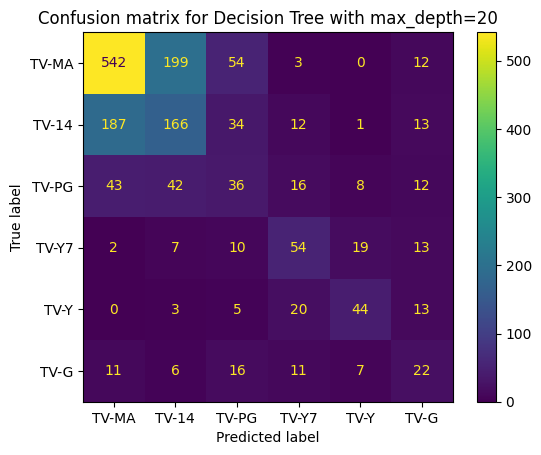

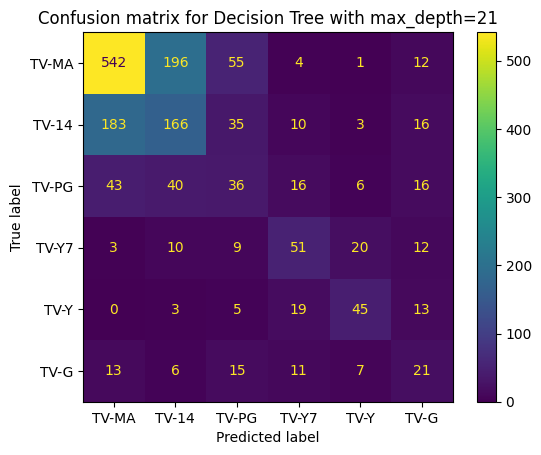

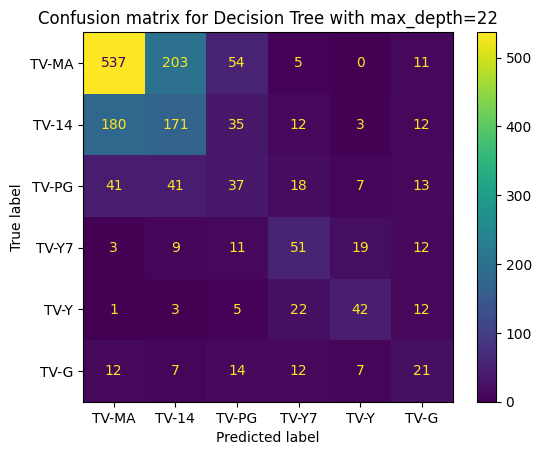

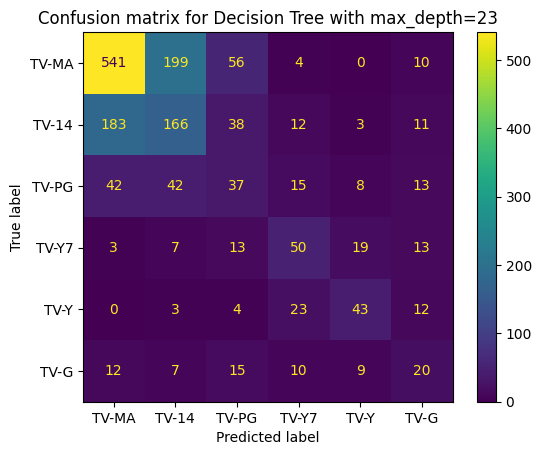

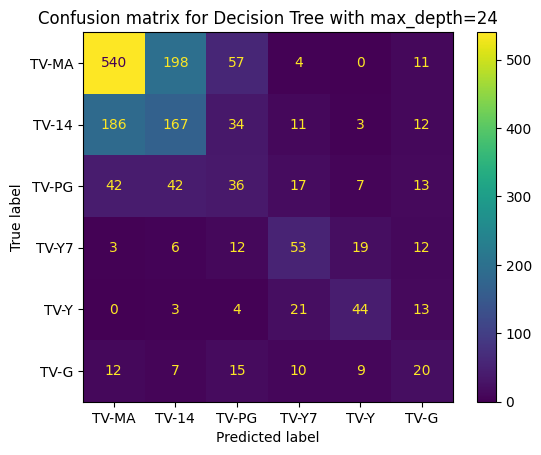

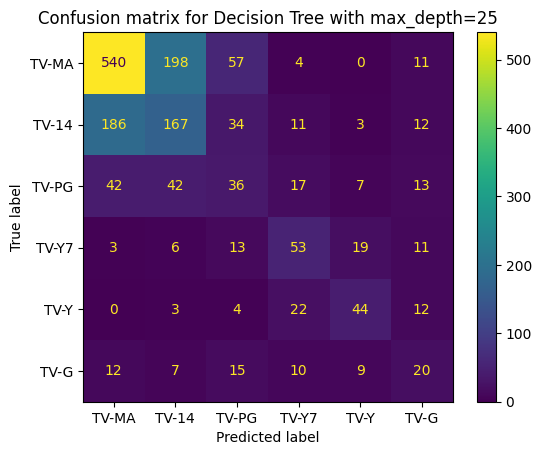

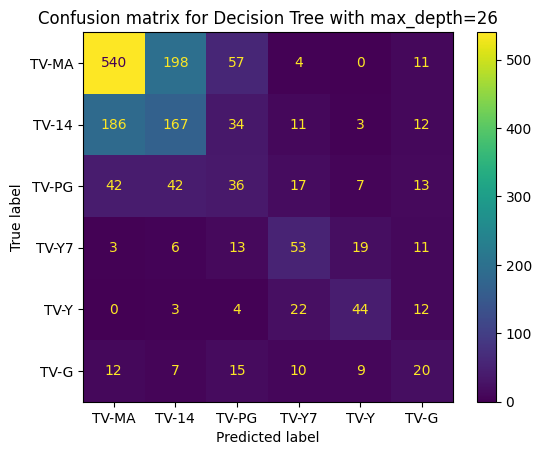

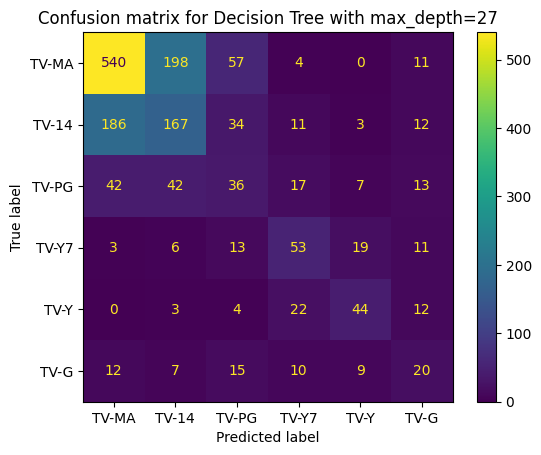

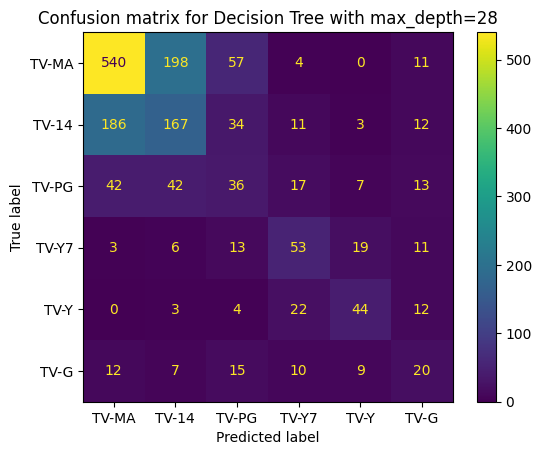

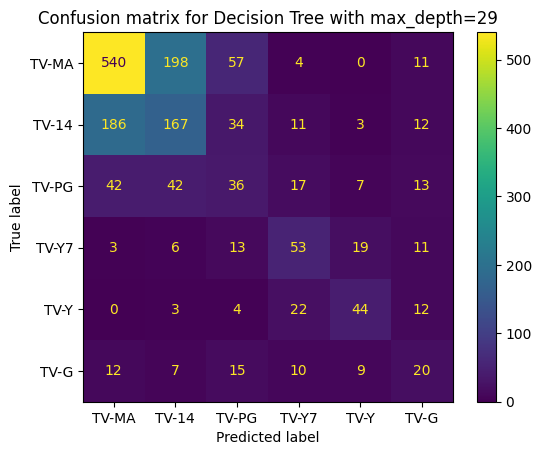

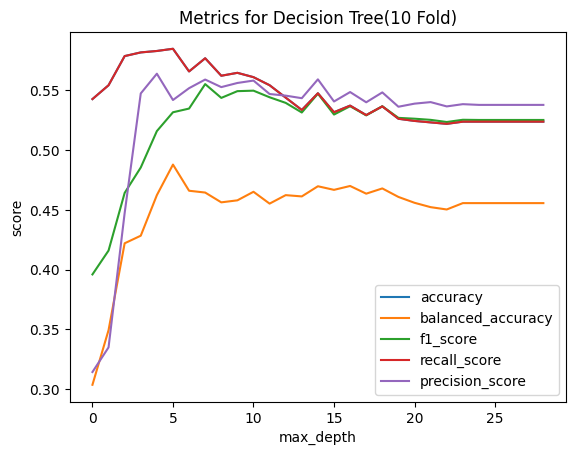

{'accuracy': [0.5422949002217294, 0.5538470066518848, 0.5781929046563193, 0.5812564671101257, 0.5824538063562453, 0.5842904656319291, 0.5653769401330377, 0.5763747228381375, 0.5617849223946785, 0.5642128603104213, 0.5606023651145602, 0.5538802660753881, 0.5435254988913526, 0.5332150776053215, 0.5471581670362158, 0.5313451589061345, 0.5368477457501848, 0.5289430894308943, 0.5362084257206209, 0.5258721359940872, 0.5240576496674058, 0.5228455284552845, 0.521618625277162, 0.523440502586844, 0.523440502586844, 0.523440502586844, 0.523440502586844, 0.523440502586844, 0.523440502586844], 'balanced_accuracy': [0.3038024524060757, 0.3494093618365145, 0.42191472857697354, 0.4282524975248639, 0.4621110321367565, 0.48762211640569914, 0.46577994687702307, 0.4642753381067976, 0.4560945392356162, 0.45777288659083115, 0.46491235031403305, 0.45503336521894655, 0.4621136494980321, 0.46104909637529606, 0.46952897458520376, 0.4665251568133003, 0.4697623334753519, 0.46334094764582856, 0.46771337033243354, 

In [69]:
from sklearn.model_selection import KFold

# Define the number of folds
k = 10

# Create a KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Define a function to train and evaluate the decision tree using K-fold cross-validation
def train_and_evaluate_tv_shows(X, y, depth):
    scores = {label: [] for label in evaluation_score_labels}
    aggregate_cm = np.zeros((6, 6), dtype=int)
    # Loop over the folds
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the decision tree
        dt = DecisionTreeClassifier(criterion="entropy", random_state=1, max_depth=depth)
        dt.fit(X_train, y_train)

        # Evaluate the decision tree
        y_pred = dt.predict(X_test)
        evaluation_result = get_evaluation_scores(y_test, y_pred)
        # if depth == 3:
        #   plot_evaluation(dt,X,y_test,y_pred,depth)
        cm = confusion_matrix(y_test, y_pred, labels=[2,0,3,5,4,1])
        aggregate_cm += cm

        # Add the evaluation scores to the scores dictionary
        for label in evaluation_score_labels:
            scores[label].append(evaluation_result[label])


    # Calculate the mean evaluation scores over all folds
    mean_scores = {label: np.mean(scores[label]) for label in evaluation_score_labels}


    disp = ConfusionMatrixDisplay(confusion_matrix=aggregate_cm,display_labels=['TV-MA', 'TV-14', 'TV-PG', 'TV-Y7', 'TV-Y', 'TV-G'])
    disp.plot()
    plt.title(f"Confusion matrix for Decision Tree with max_depth={depth}")
    plt.show()

    return mean_scores

tv_shows_score_data_kfold = {
    "accuracy": [],
    "balanced_accuracy": [],
    "f1_score": [],
    "recall_score": [],
    "precision_score": [],
}
tv_shows_depth_scores_kfold = {}
for depth in range(1, max_depth):
  DT_result = train_and_evaluate_tv_shows(X_tvshow, y_tvshow, depth)
  tv_shows_score_data_kfold['accuracy'].append(DT_result['accuracy'])
  tv_shows_score_data_kfold['balanced_accuracy'].append(DT_result['balanced_accuracy'])
  tv_shows_score_data_kfold['f1_score'].append(DT_result['f1_score'])
  tv_shows_score_data_kfold['recall_score'].append(DT_result['recall_score'])
  tv_shows_score_data_kfold['precision_score'].append(DT_result['precision_score'])
  tv_shows_depth_scores_kfold[depth] = DT_result
plot_evaluation_scores(tv_shows_score_data_kfold, title="Metrics for Decision Tree(10 Fold)", xlabel="max_depth")
print(tv_shows_score_data_kfold)

In [70]:
score_table_tv_shows = pd.DataFrame(tv_shows_score_data_kfold, index=range(1, max_depth))
score_table_tv_shows

accuracy  balanced_accuracy  f1_score  recall_score  precision_score
1   0.542295           0.303802  0.395926      0.542295         0.314447
2   0.553847           0.349409  0.415844      0.553847         0.335032
3   0.578193           0.421915  0.463975      0.578193         0.447199
4   0.581256           0.428252  0.485181      0.581256         0.547007
5   0.582454           0.462111  0.515577      0.582454         0.563478
6   0.584290           0.487622  0.531289      0.584290         0.541520
7   0.565377           0.465780  0.534384      0.565377         0.551400
8   0.576375           0.464275  0.554799      0.576375         0.558612
9   0.561785           0.456095  0.543292      0.561785         0.552292
10  0.564213           0.457773  0.548918      0.564213         0.555743
11  0.560602           0.464912  0.549327      0.560602         0.557752
12  0.553880           0.455033  0.543811      0.553880         0.546530
13  0.543525           0.462114  0.539132      0.543525         0.545176
14  0.533215           0.461049  0.531098      0.533215         0.543044
15  0.547158           0.469529  0.546837      0.547158         0.558778
16  0.531345           0.466525  0.529392      0.531345         0.540297
17  0.536848           0.469762  0.536344      0.536848         0.548169
18  0.528943           0.463341  0.528730      0.528943         0.539627
19  0.536208           0.467713  0.536295      0.536208         0.547880
20  0.525872           0.460613  0.526615      0.525872         0.535916
21  0.524058           0.455723  0.525924      0.524058         0.538491
22  0.522846           0.452083  0.524958      0.522846         0.539772
23  0.521619           0.450141  0.523168      0.521619         0.536185
24  0.523441           0.455456  0.525023      0.523441         0.538060
25  0.523441           0.455456  0.524865      0.523441         0.537450
26  0.523441           0.455456  0.524865      0.523441         0.537450
27  0.523441           0.455456  0.524865      0.523441         0.537450
28  0.523441           0.455456  0.524865      0.523441         0.537450
29  0.523441           0.455456  0.524865      0.523441         0.537450